<h1 style="text-align:center; font-size:38.0px">Disaster Tweets Predictions</h1>

<img src="disaster_intro_sd1_upscale.png" alt="disaster in paris">
<span style='font-family:Sabon;font-size:8.0pt;'>
    <b>Image generated via <a href='https://github.com/CompVis/stable-diffusion'>Stable Diffusion</a></b>
</span>


<span style='font-family:Sabon;font-size:24.0pt;'>
    <b>Table of Contents</b>
</span>
<span style='font-family:Sabon;font-size:16.0pt;line-height:1.5'>
    <ul>        
        <li><a href='#intro'>1. Introduction</a></li>
        <li><a href='#func'>2. Define Functions</a></li>
        <li><a href='#import_data'>3. Import Data and Libraries</a></li>
        <li><a href='#gen_info'>4. General Information</a></li>        
        <li><a href='#pp'>5. Preparing Data for Analysis</a></li>
        <ul>
            <li><a href='#pp_dup'>5.1. Check for Duplicates</a></li>
            <li><a href='#pp_miss'>5.2. Checking for Missing Values</a></li>
            <li><a href='#pp_ascii'>5.3. Remove Non Ascii Characters</a></li>
        </ul>
        <li><a href='#spacy'>6. Language Processing with spaCy</a></li>
        <ul>
            <li><a href='#spacy_ext'>6.1. Setting Up spaCy and Defining Custom Extensions</a></li>
            <li><a href='#spacy_nlp'>6.2. NLP with spaCy</a></li>
            <li><a href='#spacy_feat'>6.3. Feature Engineering Using Text Properties and spaCy Properties</a></li>
            <li><a href='#spacy_lem'>6.4. Cleaning and Lemmatization</a></li>
        </ul>
        <li><a href='#EDA'>7. Exploring our New Features</a></li>
            <ul>
                <li><a href='#EDA_cor'>7.1. Pearson Correlation Heatmap Matrix</a></li>
                <li><a href='#EDA_viz'>7.2. Visualize Target Variable Against Features</a></li>
            </ul>    
        <li><a href='#vector'>8. WordCloud and TF-IDF Vectorizing</a></li>
            <ul>
                <li><a href='#vector_cloud'>8.1. Word Clouding</a></li>
                <li><a href='#vector_tfidf'>8.2. Transforming Tweets to TF-IDF Vectors</a></li>
            </ul>
        <li><a href='#ML'>9. Choosing Our Machine Learning Model</a></li>
        <li><a href='#cv'>10. Hyperparameter Optimization and Gridsearch</a></li>
        <ul>
            <li><a href='#cv_rfc'>10.1. RFC Randomized Search CV</a></li>
            <ul>
                <li><a href='#cv_rfc_comp'>10.1.1. Updated Model vs Original Model</a></li>
                <li><a href='#cv_rfc_it1'>10.1.2. CV 2nd Iteration</a></li>
            </ul>
            <li><a href='#cv_xgb'>10.2. XGBC Randomized Search CV</a></li>
            <ul>
                <li><a href='#cv_xg_it1'>10.2.1. 2nd Iteration</a></li>
                <li><a href='#cv_xg_it2'>10.2.2. 3rd Iteration</a></li>
            </ul>
            <li><a href='#cv_final'>10.3. Final Models Showcase</a></li>
        </ul>
        <li><a href='#predict'>11. Predict Disaster Tweets</a></li>
        <li><a href='#conc'>12. Results and Conclusions</a></li>
        <li><a href='#ref'>13. References</a></li>
    </ul>
</span>

<a id="intro"></a>
<h2>1. Introduction</h2>

<span style='font-family:sabon;font-size:13pt;'>
    In this day and age, we get our reports of certain worldly events from many different places. One of those places is Twitter, which has been shown to be very active during times of disaster, war, and oppression.<br><br>
    An important aspect of this to consider, is that twitter is one of the information avenues which humanitarian relief agencies and news agencies use to get their most pressing up to date information.<br><br>
    However, on Twitter anybody can tweet, and a tweet which at first glance may seem like real news of a disaster can sometimes be a simple exaggerated joke or even an ad of some kind.<br>
    For this reason it's important to be able to quickly identify if the subject of a tweet describes a real disaster or something else entirely.<br><br>
    Our task for today will be to create a machine learning model that could make this differentiation with high accuracy.<br><br>
    We will check the integrity of the data, employing natural language processing methods to generate features for our model, optimize it using cross validation, and eventually use it to classify tweets in the unseen test set provided to us!<br><br>
    So let's dive in!!<br><br>
    <b style='font-size:11pt;'>This work is based on a Kaggle competition named "Natural Language Processing with Disaster Tweets" and uses data which is available through the <a href='https://www.kaggle.com/competitions/nlp-getting-started'>competition page</a></b>.<br><br>
    </span>

<a id="func"></a>
<h2>2. Define Functions</h2>

In [1]:
def nlp_looker(df,index=0 , rand= False):
    """
    This function was designed for debugging this project.
    a spacy doc is taken from a specific or random index
    of the main dataframe containing the docs in its text_nlp column
    and a report is produced showing all the tokens in order, their parts of speech label,
    entity labels if they have any, and their lemma form.
    
    Parameters:
        doc(spacy doc): a doc file containing the tokens processed by spacy.
        index(int): index of dataframe to retrieve report for (default: 0)
        rand(bool): whether to choose random index. can be used instead of
                    the index argument.
    Return:
        Report of each token in the doc, its labels, text, and lemma.
    """
    if rand == True:
        index = rd.randint(0, df.shape[0])
        print('Showing report for index: {}'.format(index))
    #show text
    print('Text:', " ".join([token.text for token in df.iloc[index]['text_nlp']]),'\n_____________________________')
    #show pos report
    print('Pos Report:\n_____________________________')
    display([(token.pos_, token.text) for token in df.iloc[index]['text_nlp']])
    #show ent report
    print('Entity Report:\n_____________________________')
    display([(ent.label_, ent.text) for ent in df.iloc[index]['text_nlp'].ents])
    #show lemma report
    print('Lemma Report:\n_____________________________')
    display([(token.lemma_, token.text) for token in df.iloc[index]['text_nlp']])
    
def val_counts(df_list, drop_na= True, n=5):
    
    """
    This function returns a dataframe's 
    column values and their value counts
    in absolute and relative values

    Parameters:
        df_list(list): a list of one or more dataframes.
                       Columns should be specified for
                       the columns which value counts you need.
        n (int): number of rows to report for each column. (Default = 5)
    Returns:
        A report of the first highest n value counts(absolute and relative) in each specified column
        for each df in the df_list.

    """
    #enumerate df list for name reference
    df_num= [i+1 for i, df in enumerate(df_list)]
    
    for df in df_list:
        try:
            df_name = df.custom_name
        except:
            df_name = 'Dataframe {}'.format(df_num[0])
            
        #pop first df number after successful naming
        df_num.pop(0)
        
        print('Top {} Value Counts for {} :\n'.format(n,df_name))
        for column in df.columns:
            print('\nColumn: {}'.format(column))
            val_normalized = df[column].value_counts(normalize=True, dropna= drop_na).to_frame()
            val_absolute = df[column].value_counts(dropna= drop_na).to_frame()
            val_final = val_absolute.merge(val_normalized, right_index=True, left_index=True)
            val_final.columns = ['{}'.format(column+' '+'absolute'),'{}'.format(column+' '+'relative')]
            display(val_final.head(n))
        print('\n___________________________________________________\n')
            
def sample_display(df_list,n=5, random_state= None):
    """
    This function displays samples
    of all the dataframes in the list.
    n rows default 5
        
    Parameters:
    
        df_list: list of pandas dataframes
    
        n (int): number of sample rows to return
        
    Returns:
    
        n sample rows from each df listed
    
    """
    df_num= [i+1 for i, df in enumerate(df_list)]
    for df in df_list:   
        try:
            df_name = df.custom_name
        except:
            df_name = 'Dataframe {}'.format(df_num[0])
    #set df name
        print('{} sample:'.format(df.custom_name))
        display(df.sample(n, random_state=random_state))
        print('\n___________________________________\n')
        
def dup_display(df_list):
    """
    This function returns the
    number of duplicated rows
    in each df in the list
        
    Parameters:
        df_list: list of pandas dataframes
    
    Returns:
        report of duplicated rows in each df listed
        report of duplicates diversity in each df listed
    
    """
    alias= 0
    for df in df_list:
        dup_sum = df.duplicated().sum()
        dup_perc = dup_sum / df.shape[0]
        try:
            df_name = df.custom_name
        except:
            df_name = 'Unknown Dataframe {}'.format(alias)
            alias += 1
        
        print('{} :\nDuplicated Values: {}\n% duplicated rows: {:.2%}\n'.format(
            df_name,dup_sum,dup_perc
        )
             )
        print('Duplicates distribution diversity:')
        for col in df[df.duplicated()].columns:
            print('{} : {}'.format(
                col,df[df.duplicated()][col].nunique()
        )
             )
        print()
    
def percentile_report(series, percentile=[1, 5, 95, 99]):
    """
    Prints a report of the percentiles defined in
    the percentile argument for a given series, as well
    as the minimum and maximum values.
    
    Parameters:
        series(pd.Series): a pandas array
        percentile(list): a list of percentiles to report upon
    Returns:
        A report of values by percentiles.
    """
    print(series.name, 'Percentile Report:\n\n')
    print('Minimum value: {}'.format(series.min()))
    for perc in percentile:
        print('{} Percentile: {}'.format(perc, np.percentile(series, perc)))
        print('___________________________________')
        print('\n')
    print('Maximum value: {}'.format(series.max()))

def id_compare_tag(row, named_column, value_list, id_list):
    """
    This function returns an id corresponding to
    the value(int) in the value list by comparing the
    value to the list.
    named_column is the name of the column that you want to categorize
    this should be used with the apply() method
    """
    df_row = row[named_column]
    for i in range(len(value_list)):
        if df_row <= value_list[i]:
            return (id_list[i])
        
def spread_df(df, one_hot_encode):
    """
    one hot encode columns and return df
    
    parameters:
        df: 
            dataframe whose columns to encode
        one_hot_encode (list):
            list of column names to encode
            
    returns:
        dataframe with encoded columns
    """
    return(pd.get_dummies(df, columns= one_hot_encode))

#ML

def classification_prediction(
    m,
    X_columns,
    X_train,
    X_test,
    y_train,
    y_test,
    class_metrics= dict(
        accuracy=True, percision= True, recall= True, F1= True
        ),
    proba_metrics = False,
    imp_n = 10
    ):
    """
    This function trains classification models
    and prints out a report of metrics
    and feature importance ranking

    Parameters:
        m(list): 
            a list of models to train
        
        X_train(pandas series):
            array of features
            
        X_test(pandas series):
            array of features for testing
        
        y_test (pandas series): 
            array of target variable test data
        
        class_metrics (dict):
            dictionary of classification metrics to calculate
        
        proba_metrics (bool):
            if True, probability prediction will be calculated
        imp_n (int):
            determines the number of top features shown in the
            feature importance graph
    Returns:
        report of model efficiency using classification metrics.
        report of feature importance.

    """
    #train model and predict
    for model in m:
        score_type = 'MDI'
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        #print report
        print('Model: {}\n'.format(model.__class__.__name__))
        for key,value in class_metrics.items():
            if value == True and type(model) in [
                type(LogisticRegression()),
                type(SGDClassifier()), 
                type(RandomForestClassifier()),
                type(DecisionTreeClassifier()),
                type(GradientBoostingClassifier()),
                type(XGBClassifier())
            ]:
                metric_calc(key, y_test, predictions)
                
        if proba_metrics == True:
            probabilities = model.predict_proba(X_test)[:,1]
            metric_calc('ROC_AUC', y_test,predictions, proba=probabilities)
            
        #display feature importance dataframe
        if type(model) in [type(RandomForestClassifier()),type(DecisionTreeClassifier()), type(GradientBoostingClassifier())]:
            importances = model.feature_importances_
            imp_df = pd.DataFrame(
                data=pd.Series(importances).values, index= X_columns, columns= ['importance']
                )
            imp_df.sort_values('importance', ascending=False, inplace=True)
            display(imp_df.head())
            
        elif type(model) in [type(LogisticRegression()),type(SGDClassifier())]:
            feature_weights  = model.coef_
            weight_0 = model.intercept_
            imp_df = pd.DataFrame(data=pd.Series(feature_weights[0]).values, index= X_columns, columns= ['importance'])
            imp_df = abs(imp_df).sort_values('importance', ascending= False)
            display(imp_df.head())
            
        elif type(model) == type(XGBClassifier()):
            #uncomment for feature choice - needs work because manual input stops notebook from running
            #score_type = input('choose score type for XGBoost feature importance plot ["weight", "gain", "cover"]')
            #use weight as default score type
            score_type = 'weight'
            #get feature : importance score dictionary
            feature_dict = model.get_booster().get_score(importance_type=score_type)
            #export keys and values
            keys = list(feature_dict.keys())
            values = list(feature_dict.values())
            
            #transform keys to mirror original feature names
            strip_key = [key.replace('f', "") for key in keys]
            index = np.take(X_columns, strip_key, 0)
            
            #build feature dataframe
            imp_df = pd.DataFrame(
                data=values,
                index=index, 
                columns=['score']
                ).sort_values(by = 'score', ascending=False)
            display(imp_df.head())
            
        print()
        #display feature importance plot
        sns.set_palette(palette= 'deep')
        fig, ax = plt.subplots(figsize=(12,10))
        imp_df.head(imp_n).plot.bar(ax=ax)
        ax.set_title("{} Model Feature Importances Using {}".format(model.__class__.__name__, score_type), fontsize= 24)
        if type(model) != type(XGBClassifier()):
            ax.set_ylabel("Mean decrease in impurity", fontsize= 20)
        else:
            ax.set_ylabel("{} Score".format(score_type))
        ax.set_xlabel("Feature", fontsize= 20)
        fig.tight_layout()

        #change tick labels font size
        cax = plt.gcf().axes[0]
        cax.tick_params(labelsize=16)

            
        
        plt.show()
        
def metric_calc(metric_name, y_test, predictions=None, proba=None):
    """
    This function returns the result
    of a metric calculation held in
    its function dictionary

    Parameters:
        metric_name(str): 
            a string that corresponds to
            one of the keys in the function dictionary
            
        y_test (pandas series): 
            array of target variable test data
        
        predictions (numpy.ndarray):
            result of prediction of test data
        
        proba (numpy.ndarray):
            results of probability prediction of test data
    Returns:
        Result of metric calculation

    """
    function_dict = dict(accuracy= 'Accuracy: {:.2f}'.format(accuracy_score(y_test,predictions)),
                        percision = 'Percision: {:.2f}'.format(precision_score(y_test,predictions)),
                        recall = 'Recall: {:.2f}'.format(recall_score(y_test,predictions)),
                         F1 = 'F1 Score: {:.2f}'.format(f1_score(y_test, predictions)), 
                        )
    if metric_name == 'ROC_AUC':
        return(print('ROC AUC: {:.2f}'.format(roc_auc_score(y_test, proba))))
    return(print(function_dict[metric_name]))

<a id="func_proc"></a>
<h3>Word Processing and Tagging Functions</h3>

In [2]:
def url_strip(row):
    """
    This function strips common URLs from text.
    It is compatible with forms of http, https and www.
    
    Parameters:
        row(str): row fed through pandas df or text.
    Returns:
        Text without URLs
        
    """
    clean_string = re.sub(r'(https?:\/\/|w{3})[.\S]+\.[.\S]+', '', row).strip()
    #clean double spaces
    clean_string = re.sub(' +', ' ', clean_string)
    
    return clean_string

def punctuation_strip(text):
    """
    This function strips punctuation from text.
    
    Parameters:
        text(str): text to process.
    Returns:
        Text without punctuation.
        
    """
    punctuation_pattern = """[!"'()+,\/:;<=>\-?[\]_`{|}.~]"""
    clean_string = re.sub(punctuation_pattern, "",text).strip()
    clean_string = re.sub(r' +', ' ', clean_string)
    return clean_string
    
def tag_strip(text):
    """
    This function strips hashtags(#) and mentions(@) from text.
    Attached text is also removed.
    
    Parameters:
        text(str): text to process.
    Returns:
        Text without hashtags, mentions and their attached text.
        
    """
    clean_hashtag = re.sub(r'\B\#([\w\-]+)', '', text).strip()
    clean_mention = re.sub(r'\B\@([\w\-]+)', '', clean_hashtag).strip()
    clean_string = re.sub(' +', ' ',clean_mention)
    
    return clean_string

def word_counter(text, mode='word_count'):
    """
    This function performs multiple word processing tasks
    based on the mode parameter.
    
    Parameters:
        text(str): Text to process.
        mode(str): Decides the task the function performs on the text (default: 'word_count')
                    char_count - counts characters in the text
                    word_count - counts words in text
                    unique_word - counts unique words in text
                    average - calculates the average word length in the text
                    capital_count - counts the amount of capital letters in the text
                    all_capital_count - counts words that have all capital letters
                    punct_count - counts punctuation marks in the text
                    punct_uniq - counts unique punctuation in the text
    Returns:
        output based on the mode argument (see parameters)
    
    """
    if mode == 'char_count':
        char_count = len(text)
        
        return char_count
    
    if mode == 'word_count':
        word_count = len(text.split(" "))
        
        return word_count
    
    if mode == 'unique_word':
        uq_word_count = len(set(text.split(" ")))
        
        return uq_word_count
    
    if mode == 'average':
        word_cnt_list = [len(word) for word in text.split(" ")]
        
        return sum(word_cnt_list) / len(word_cnt_list)
    
    if mode == 'capital_count':
        capital_chars = sum([char.isupper() for char in text])
        
        return capital_chars
    
    if mode == 'all_capital_count':
        all_capital = sum([word.isupper() for word in text.split(" ")])
            
        return all_capital
        
    if mode == 'punct_count':
        punct_count = len(re.findall("""[!"'()+,\/:;<=>\-?[\]_`{|}.~]""", text))
        
        return punct_count
    
    if mode == 'punct_uniq':
        punct_uniq = len(set(re.findall("""[!"'()+,\/:;<=>\-?[\]_`{|}.~]""", text)))
        
        return punct_uniq
        
def word_processor(text, mode='word_count'):
    """
    This function leverages the url_strip, tag_strip and word_counter
    functions to clean text and process it.
    
    Parameters:
        text(str): Text to process.
        mode(str): Decides the task the function performs on the text (default: 'word_count')
                    char_count - counts characters in the text
                    word_count - counts words in text
                    unique_word - counts unique words in text
                    average - calculates the average word length in the text
                    capital_count - counts the amount of capital letters in the text
                    all_capital_count - counts words that have all capital letters
                    punct_count - counts punctuation marks in the text
                    punct_uniq - counts unique punctuation in the text
    Returns:
            output based on the mode argument (see parameters)
    """
    text_stripped_url = url_strip(text)
    text_stripped_tags = tag_strip(text_stripped_url)
    
    #if processing punctuation do so before cleaning punctuation
    if mode in ['punct_count', 'punct_uniq']:
        result_str = word_counter(text_stripped_tags, mode=mode)
        
        return result_str
    
    clean_string = punctuation_strip(text_stripped_tags)
    result_str = word_counter(clean_string, mode=mode)
    
    return(result_str)

#define tag catcher for binary feature creation
def tag_catcher(doc, param):
    """
    This functions uses features of the spacy module
    to output binary facts regarding certain token parameters
    and linguistic features.
    
    Parameters:
        doc(spacy doc): list of tokens in a spacy doc
        param(str): decides which feature to test.
                    url: check for URL in tokens
                    num: check for a token that is a number or number word
                    gpe: check for a token that describes a country
                    loc: check for a token that describes a location
                    fac: check for a token that describes a facility
                    mention: check if token is a mention(@) - requires spacy custom extension
                    hashtag: check if a token is a hashtag(#) - - requires spacy custom extension
    Returns:
        Binary output based on parameter given (see Parameters)
    """
    if param == 'url':
        if True in [token.like_url for token in doc]:
            return 1
        else:
            return 0
    if param == 'num':
        if True in [token.like_num for token in doc]:
            return 1
        else:
            return 0
    if param == 'gpe':
        if 'GPE' in [ent.label_ for ent in doc.ents]:
            return 1
        else:
            return 0
    if param == 'loc':
        if 'LOC' in [ent.label_ for ent in doc.ents]:
            return 1
        else:
            return 0
    if param == 'fac':
        if 'FAC' in [ent.label_ for ent in doc.ents]:
            return 1
        else:
            return 0
    if param == 'mention':
        if True in [token._.is_mention for token in doc]:
            return 1
        else:
            return 0
    if param == 'hashtag':
        if True in [token._.is_hashtag for token in doc]:
            return 1
        else:
            return 0
        
#build pos_ counter

#define global variable
VALID_POS = {'NOUN', 'PROPN', 'PRON', 'VERB', 'ADV', 'ADJ'}
def pos_counter(doc, pos):
    """
    This function counts parts of speech in a spacy doc
    
    Parameters:
        doc(spacy doc): list of spacy tokens in a doc
        pos(str): Part of speech to count
                    must be one of: ('NOUN', 'PROPN', 'PRON', 'VERB', 'ADV', 'ADJ')
    Returns:
        count of part of speech found in the doc
    """
    if pos.upper() not in VALID_POS:
        raise ValueError("pos must be one of {}".format(VALID_POS))
    pos_count = [token.pos_ for token in doc].count(pos.upper())
    
    return pos_count

#define lemma extracting function
def extract_lemmas(doc):
    """
    This functions rebuilds the tokens in the doc
    into a text with the lemmas of each token in order.
    Note: This function ignores tokens which have @ attached,
    are numbers or contain numbers within them
    
    Parameters:
        doc(spacy doc): list of spacy tokens in a doc
    Returns:
        doc token lemmas as text in the same order, without numbers or mentions
        
    """
    str_with_lemma = " ".join(
        [
            token.lemma_ for token in doc \
                if token._.is_mention == False\
                and token.like_num == False\
                and token._.is_strictnum == False\
        ]
    )
    clean_str_lemma = str_with_lemma.replace('#', '').strip()
    
    return clean_str_lemma

<a id="import_data"></a>
<h2>3. Import Data and Libraries</h2>

In [3]:
#install extra packages
!pip install sidetable
!pip install wordcloud
!pip install spacy
!pip install xgboost
!pip install spacy-transformers

#import Libraries
import random as rd
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
import sidetable as stb
from matplotlib import pyplot as plt
import regex as re
import seaborn as sns
import warnings

#NLP
from wordcloud import WordCloud, STOPWORDS
import spacy
import spacy_transformers
from spacy.tokens import Token

#sklearn models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS


#sklearn splitting tool
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

#xgboost modules
from xgboost import XGBClassifier, plot_importance

#sklearn metrics
from sklearn.metrics import \
    accuracy_score, precision_score, recall_score,\
    f1_score, roc_auc_score, mean_absolute_percentage_error,\
    mean_absolute_error, mean_squared_error, r2_score, auc, roc_curve

#filter warnings
warnings.filterwarnings('ignore')

In [4]:
#get current path
path = os.getcwd()

#read data to variable
test_tweets = pd.read_csv(
    path + '\\Data\\test.csv'
)

train_tweets = pd.read_csv(
    path + '\\Data\\train.csv'
)

#name dataframe for reference
test_tweets.custom_name = 'test'
train_tweets.custom_name = 'train'

<a id="gen_info"></a>
<h2>4. General Information</h2>

In [5]:
sample_display([test_tweets, train_tweets], 2)

test sample:


,id,keyword,location,text
2909,9631,thunderstorm,NaN,RT @LivingSafely: NWS posts Severe #Thundersto...
2625,8779,siren,NaN,Ebay Snipe RT? http://t.co/tRw1OmykQz Whelen S...



___________________________________

train sample:


,id,keyword,location,text,target
5344,7628,pandemonium,Miami?Gainesville,If she don't know bout that Pandemonium album ...,0
5667,8087,rescue,NaN,Last Chance Animal Rescue has 3 new posts. htt...,0



___________________________________



<a id='pp'></a>
<h2>5. Preparing Data for Language Processing</h2>

<a id='pp_dup'></a>
<h3>5.1. Checking for Duplicates</h3>

<span style='font-family:sabon;font-size:13pt;'>
    Here we are checking for any duplicated rows within the data.<br>
    As the data contains a unique id column we should not find any duplicates if the data's integrity is preserved.<br>
    As part of our function, duplicate distribution diversity is checked as well, showing us the frequency of repeated values by column for duplicated rows.
    </span>

In [6]:
#use dup_display to check for duplicates in both datasets
dup_display([train_tweets, test_tweets])

train :
Duplicated Values: 0
% duplicated rows: 0.00%

Duplicates distribution diversity:
id : 0
keyword : 0
location : 0
text : 0
target : 0

test :
Duplicated Values: 0
% duplicated rows: 0.00%

Duplicates distribution diversity:
id : 0
keyword : 0
location : 0
text : 0



<span style='font-family:sabon;font-size:13pt;'>
    So no duplicates are present!<br>
    Great, but let's see if we detect any missing values in the rows we have.
    </span>

<a id='pp_miss'></a>
<h3>5.1. Checking for Missing Values</h3>

In [7]:
for df in [train_tweets, test_tweets]:
    display(df.stb.missing(style=True))

,missing,total,percent
location,"2,533","7,613",33.27%
keyword,61,"7,613",0.80%
id,0,"7,613",0.00%
text,0,"7,613",0.00%
target,0,"7,613",0.00%


,missing,total,percent
location,"1,105","3,263",33.86%
keyword,26,"3,263",0.80%
id,0,"3,263",0.00%
text,0,"3,263",0.00%


<span style='font-family:sabon;font-size:13pt;'>
    We do see some consistent missing values in the location and keyword columns which.<br>
    These columns contain certain keywords or the specific location the tweet was sent from.<br>
    These values are present when available and so are missing in some cases.<br><br>
    <b>This analysis will focus on processing of the tweet text itself and so we will not be using these values.</b><br>
    we can continue to prepare the data for the NLP process.
    </span>


<a id='pp_ascii'></a>
<h3>5.2. Remove Non Ascii Characters</h3>

<span style='font-family:sabon;font-size:13pt;'>
    Non ASCII characters such as accented letters like Ù can appear in textual data in many different forms and obstract our efforts to retain a clean and accurate vocabulary which we feed into our model.<br>
    For our use case, it's better to remove these characters before we begin the tokenizing process.
    </span>

In [8]:
#clean non-ascii characters
for df in [train_tweets, test_tweets]:
#define regex pattern
    na_pattern = '[^\x00-\x7F]+'
    df['text'] = df['text'].apply(lambda x: re.sub(na_pattern, '', x).strip())

<span style='font-family:sabon;font-size:13pt;'>
    While we are not quite finished with processing the text in this data, this is enough for us to be able to tokenize the data efficiently using the spaCy module.<br><br>
    So let's get to it!
    </span>

<a id='spacy'></a>
<h2>6. Language Processing with spaCy</h2>

<span style='font-family:sabon;font-size:13pt;'>
    spaCy is an open-source software library for advanced natural language processing (Also known as NLP).<br>
    It is exceptionally good at processing large volumes of text.<br>
    In this work we will be taking advantage of some of the features that spaCy provides, including the ability to modify its internal components and add additional steps of our own to the text processing.<br><br>
    In this part we will take each tweet and break it down to the words it is made of and give tags to each word using spaCy's token tagger as well as define our own taggers, such as hashtag(#) and mentions(@) tagging.<br>
    spaCy is able to tag fairly accurately terms that correspond to geopolitical entities, locations and many more, which we will use to our advantage in this work.
    </span>

<a id='spacy_ext'></a>
<h3>6.1. Setting Up spaCy and Defining Custom Extensions</h3>

In [ ]:
#download model from spacy
!python -m spacy download en_core_web_trf

#load nlp model using spacy
nlp = spacy.load('en_core_web_trf')

<span style='font-family:sabon;font-size:13pt;'>
    spaCy's tokenizer separates each word from the tweet and puts them in a special list called a "doc".<br>
    Each each word in the doc is called a token and each token has special properties.<br>
    These properties include labels such as GPE(geopolitical entity), LOC(location), NUM(number) and even the lemma form of the token <b>according to the models discretion</b>.<br><br>
    Before we use the default spaCy settings, we are going to create a few extensions that will make tagging our data easier.<br>
    These extensions will be used while processing the tweets to tag tokens with a boolean value True or False for the presence of mentions(@), hashtags(#) and words that include numbers (and not just numbers, those get the NUM label from spaCy)
    </span>

In [10]:
#define getter extensions for spacy
def get_is_mention(token):
    """
    This spaCy extension will tag a token that begins with @
    and is attached to text as a mention
    """
    re_pattern = '\B\@([\w\-]+)'
    return bool(re.search(re_pattern, token.text))

def get_is_hashtag(token):
    """
    This spaCy extension will tag a token with the text '#'
    as a hashtag (spaCy seperates # from text naturally)
    """
    return token.text == '#'

def get_is_strictnum(token):
    """
    This spaCy extension will tag numbers that aren't normally assigned the pos_ NUM.
    this will be used to parse data while extracting lemmas
    """
    re_pattern = '[0-9]'
    return bool(re.search(re_pattern, token.text))

In [11]:
#create extension to tag mentions
Token.set_extension('is_mention', getter= get_is_mention)

#create extension to tag hashtags
Token.set_extension('is_hashtag', getter= get_is_hashtag)

#create extention to tag a token that contains a number, different than spaCy's default NUM tag
#as this is stricter and will tag words such as 20yr or 90s as containing numbers as well
Token.set_extension('is_strictnum', getter= get_is_strictnum)

<a id='spacy_nlp'></a>
<h3>6.2. NLP with spaCy</h3>

In [12]:
#run model on tweet text to create docs
nlp_train_text_output = list(nlp.pipe(train_tweets['text']))
nlp_test_text_output = list(nlp.pipe(test_tweets['text']))

In [13]:
#add nlp output to df
train_tweets['text_nlp'] = nlp_train_text_output
test_tweets['text_nlp'] = nlp_test_text_output

<span style='font-family:sabon;font-size:13pt;'>
    The results of the process gives us a doc for each tweet as you can see below.<br>
    Initially this looks like a list of the words in the tweet, however hidden inside those words are spaCy's powerful linguistig features!<br>
    We will be looking at those and using them to engineer new features for our prediction model soon.
    </span>

In [14]:
#show results comparison
train_tweets[['text', 'text_nlp']].sample(5)

,text,text_nlp
1233,Video: Fire burns two apartment buildings and...,"(Video, :, , Fire, burns, two, apartment, bui..."
610,To fight bioterrorism sir.,"(To, fight, bioterrorism, sir, .)"
2855,Worried about how the CA drought might affect ...,"(Worried, about, how, the, CA, drought, might,..."
1040,I love The body shops bags??\n\n#cutekitten #c...,"(I, love, The, body, shops, bags, ?, ?, \n\n, ..."
7608,Two giant cranes holding a bridge collapse int...,"(Two, giant, cranes, holding, a, bridge, colla..."


<span style='font-family:sabon;font-size:13pt;'>
    Luckily for you, I made this function to show some of the cool features spaCy offers!
    </span>

In [15]:
#produce spacy report for tweet of index n
nlp_looker(test_tweets, 197)

Text: Surveillance Video Captures Man Removing American Flag From Long Beach Home ... - KTLA http://t.co/g0o9wiAgHu 
_____________________________
Pos Report:
_____________________________


[('NOUN', 'Surveillance'),
 ('NOUN', 'Video'),
 ('VERB', 'Captures'),
 ('NOUN', 'Man'),
 ('VERB', 'Removing'),
 ('ADJ', 'American'),
 ('NOUN', 'Flag'),
 ('ADP', 'From'),
 ('PROPN', 'Long'),
 ('PROPN', 'Beach'),
 ('NOUN', 'Home'),
 ('PUNCT', '...'),
 ('PUNCT', '-'),
 ('PROPN', 'KTLA'),
 ('X', 'http://t.co/g0o9wiAgHu')]

Entity Report:
_____________________________


[('NORP', 'American'), ('GPE', 'Long Beach')]

Lemma Report:
_____________________________


[('surveillance', 'Surveillance'),
 ('video', 'Video'),
 ('capture', 'Captures'),
 ('man', 'Man'),
 ('remove', 'Removing'),
 ('american', 'American'),
 ('flag', 'Flag'),
 ('from', 'From'),
 ('Long', 'Long'),
 ('Beach', 'Beach'),
 ('home', 'Home'),
 ('...', '...'),
 ('-', '-'),
 ('KTLA', 'KTLA'),
 ('http://t.co/g0o9wiaghu', 'http://t.co/g0o9wiAgHu')]

<a id='spacy_feat'></a>
<h3>6.3. Feature Engineering Using Text Properties and spaCy Properties</h3>

<span style='font-family:sabon;font-size:13pt;'>
    In this section we will be using the text properties of the tweets and the properties of spaCy tokens to create features for the predictions model.<br>
    The functions used to process and tag the data can be found in the <a href='#func_proc'>Processing and Tagging Functions</a> Section.<br><br>
    <b>The following features will be created:</b><br>
    <ul>
        <li>Tweet Length - This is based on the notion that often different lengths of texts are used to describe different subjects.</li>
        <li>Word Count and unique word count - Similarly, word count is also important and changes with the conveying of different sentiments and subjects.</li>
        <li>Punctuation count and unique punctuation count - we will extract this feature after we clean the URL's from the text.</li>
        <li>Average Word Length</li>
        <li>Capital Letters Count</li>
        <li>All Capital Words Count</li>
        <li>Capital Index - the ratio of all capital words out of word count.<br>This can sometimes give an indication as to the urgency or emotiveness of a sentence.</li>
    </ul>
    Quantitative Features using SpaCy:<br>
    <ul>
        <li>Noun Count</li>
        <li>Proper Noun Count</li>
        <li>Pronoun Count</li>
        <li>Verb Count</li>
        <li>Adverb Count</li>
        <li>Adjective Count</li>
    </ul>
        Binary tags using spaCy and our extensions:<br>
            <ul>
                <li>has_url (contains url)</li>
                <li>has_num (contains number)</li>
                <li>has_gpe (contains geopolitical Entity)</li>
                <li>has_loc (contains location)</li>
                <li>has_fac (contains facility)</li>
                <li>has_mention (contains mention)</li>
                <li>has_hashtag (contains hashtag)</li>
    </ul>
    </span>

In [16]:
#add features to both datasets
for df in [train_tweets, test_tweets]:
    for [new_col, param] in [
        ['has_url', 'url'],
        ['has_gpe', 'gpe'],
        ['has_loc', 'loc'],
        ['has_fac', 'fac'],
        ['has_num', 'num'],
        ['has_mention', 'mention'],
        ['has_hashtag', 'hashtag']
    ]:
        df[new_col] = df['text_nlp'].apply(tag_catcher, args = [param])
        
#add word processing features
for df in [train_tweets, test_tweets]:
    for [new_col, mode] in [
        ['char_count', 'char_count'],
        ['word_count', 'word_count'],
        ['unique_word_count', 'unique_word'],
        ['avg_word_len', 'average'],
        ['capital_char_count', 'capital_count'],
        ['all_capital_count', 'all_capital_count'],
        ['punct_count', 'punct_count'],
        ['punct_uniq', 'punct_uniq']
    ]:
        df[new_col] = df['text'].apply(word_processor, args=[mode])
        
#add pos count features
for df in [train_tweets, test_tweets]:
    for [new_col, pos] in [
        ['noun_count', 'noun'],
        ['pronoun_count', 'pron'],
        ['propernoun_count', 'propn'],
        ['verb_count', 'verb'],
        ['adjective_count', 'adj'],
        ['adverb_count', 'adv']
    ]:
        df[new_col] = df['text_nlp'].apply(pos_counter, args = [pos])
        
#calculate capital index
for df in [train_tweets, test_tweets]:
    df['capital_index'] = df['all_capital_count'] / df['word_count']

In [17]:
#show sample of results
train_tweets.sample(2, random_state= 42)

,id,keyword,location,text,target,text_nlp,has_url,has_gpe,has_loc,has_fac,...,all_capital_count,punct_count,punct_uniq,noun_count,pronoun_count,propernoun_count,verb_count,adjective_count,adverb_count,capital_index
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,"(So, you, have, a, new, weapon, that, can, cau...",0,0,0,0,...,0,2,2,2,2,0,2,4,1,0.000000
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,"(The, f$&amp;@ing, things, I, do, for, #, GISH...",0,0,0,0,...,1,3,3,5,1,1,3,1,1,0.052632


<a id='spacy_lem'></a>
<h3>6.4. Cleaning and Lemmatization</h3>

<span style='font-family:sabon;font-size:13pt;'>
    In this section we will use our custom function to extract the lemmatized form of each token and reform the tweet.<br>
    In this process we also strip several things from the text:<br>
    <ul>
        <li>mentions and their attached text.</li>
        <li>numbers or words with numbers.</li>
        <li>hashtags WITHOUT their attached text - many hashtags in our case could be incredibly informative as they are almost like powerful summaries of the tweet subject.</li>
        <li>remaining spaces after cleanup.</li>
        <li>punctuation characters.</li>
    </ul>
    </span>

In [18]:
#extract lemmas of tokens back into text
train_tweets['lem_text'] = train_tweets['text_nlp'].apply(extract_lemmas)
test_tweets['lem_text'] = test_tweets['text_nlp'].apply(extract_lemmas)

#clean urls from text
for df in [train_tweets, test_tweets]:
    df['lem_text'] = df['lem_text'].apply(url_strip)
    
#clean punctuation
for df in [train_tweets, test_tweets]:
    df['lem_text'] = df['lem_text'].apply(punctuation_strip)

<a id='EDA'></a>
<h2>7. Exploring our New Features</h2>

<span style='font-family:sabon;font-size:13pt;'>
    In this section we will visualize some of our new features and try to see how they correlate with our target variable.<br>
    </span>

<a id='EDA_cor'></a>
<h3>7.1. Pearson Correlation Heatmap Matrix</h3>

<span style='font-family:sabon;font-size:13pt;'>
    The Pearson Correlation Coefficient is a measure of linear correlation between two sets of data.<br>
    We use this measure to find an indication of a correlative relationship between two features.<br>
    For this purpose we create a heatmap where the darker colors show a higher correlation.<br>
    </span>

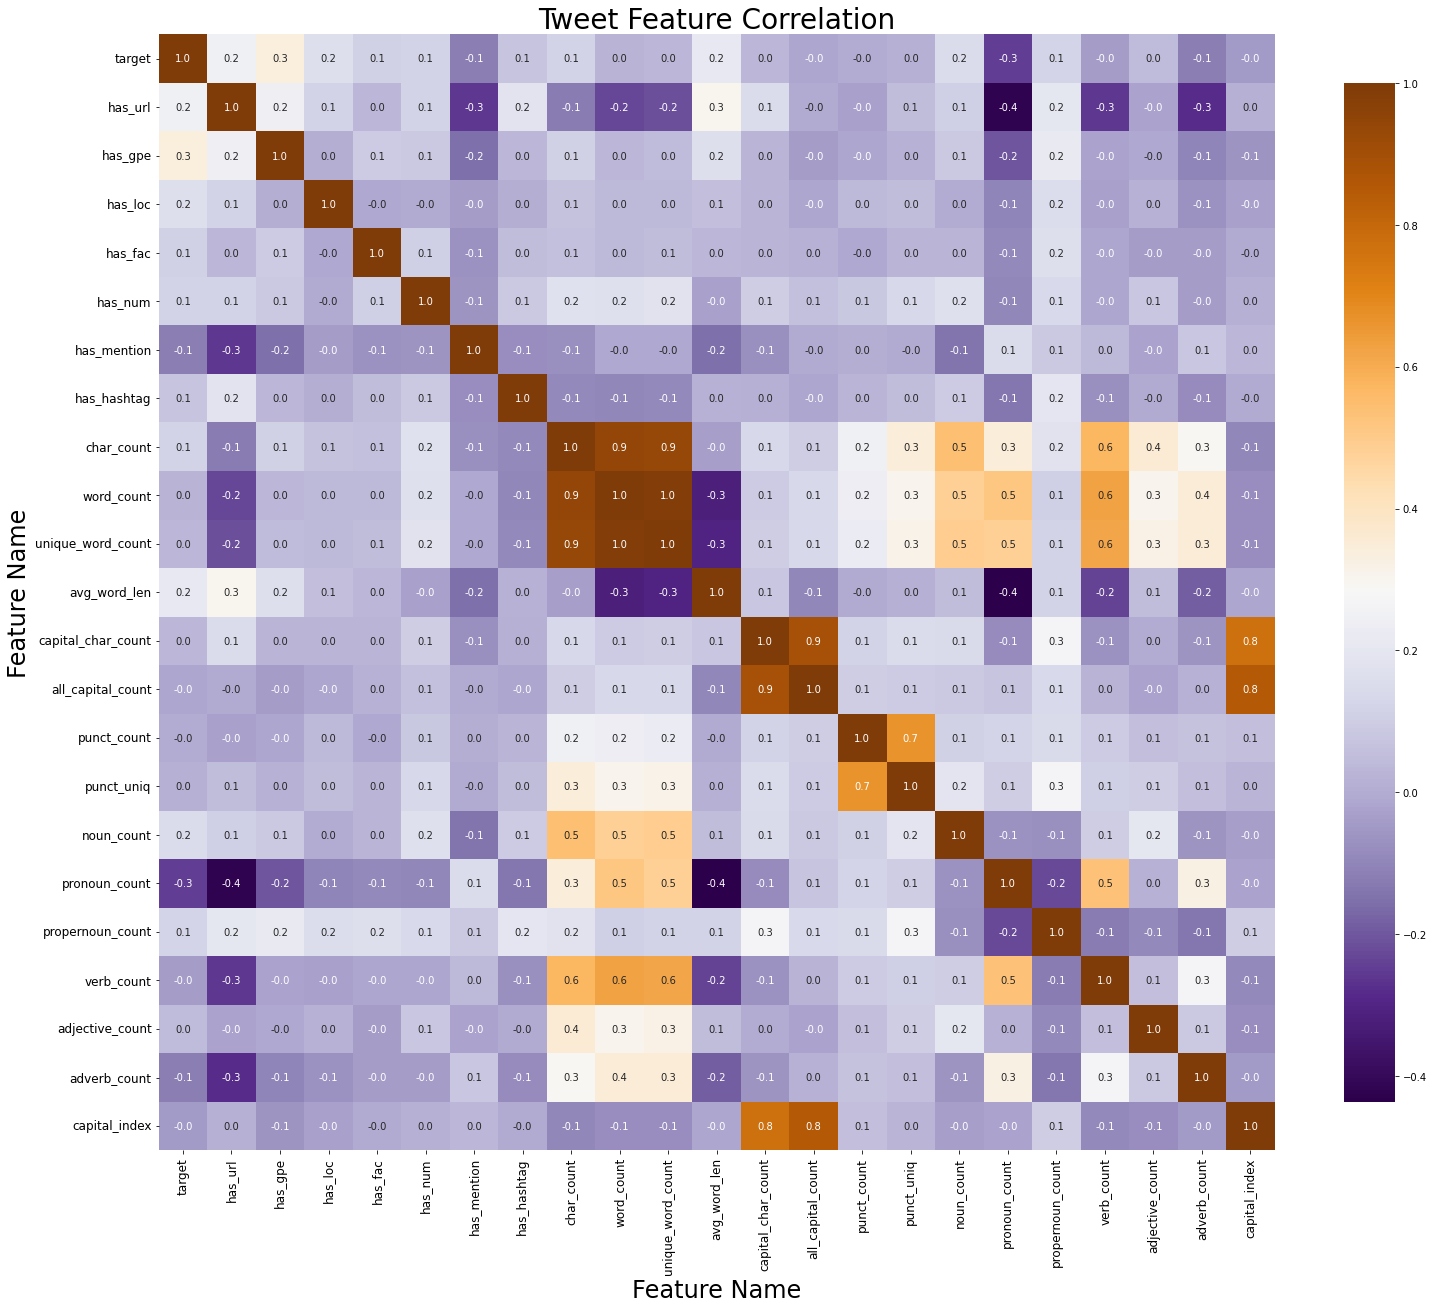

In [19]:
#prepare dataframe with relevant columns
feature_EDA = train_tweets.drop(
    [
        'keyword',
        'location',
        'text',
        'text_nlp',
        'lem_text',
        'id'
    ],axis=1)

#plot correlation heatmap
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(
    data= feature_EDA.corr(),
    annot=True,
    square=True,
    fmt= '.1f',
    cbar_kws={"shrink": 0.75},
    cmap='PuOr_r').set_title('Tweet Feature Correlation', fontsize=28)

#change tick labels font size
cax = plt.gcf().axes[0]
cax.tick_params(labelsize=12)

#set axes label
plt.xlabel("Feature Name", fontsize = 24)
plt.ylabel("Feature Name", fontsize = 24)

plt.show()

<span style='font-family:sabon;font-size:13pt;'>
    <b><u>Results:</u></b><br><br>
    Looking at the first column, where target is on the x axis, we see a couple of weak albeit interesting connections:<br>
    <ul>
    <li>Negative correlation with pronoun count - this means that as we have less pronouns in the tweet, the more it tends to be a true disaster tweet.</li>
        <li>Positive correlation with has_gpe - this means that when we have tweets that mention a country, they have a higher chance of being related to real disasters.</li>
    </ul>
    <b>It's important to note that pearson correlation does not indicate a relationship of causation. It just shows us that there is some kind of relationship between these fields, which remains to be explored.</b>
    </span>

<a id='EDA_viz'></a>
<h3>7.2. Visualize Target Variable Against Features</h3>

<span style='font-family:sabon;font-size:13pt;'>
    We will use bar charts to quickly visualize the target variable against all of the different feautres we created.<br>
    Since we have many features, this will be a long section, but there will be a summary at the end!
    </span>

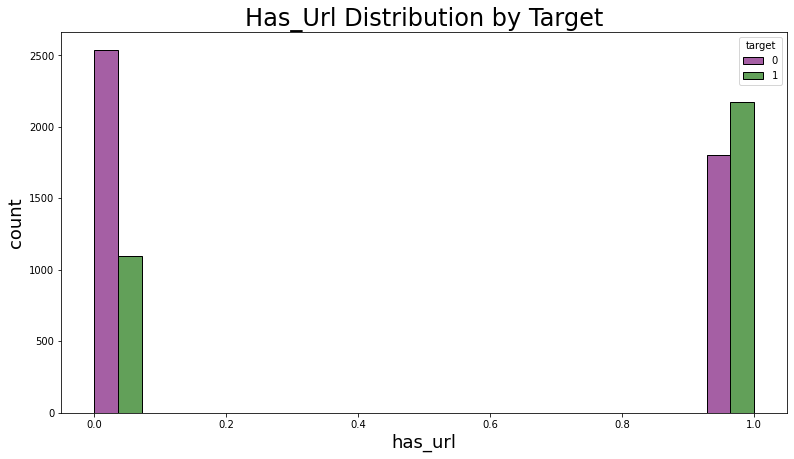

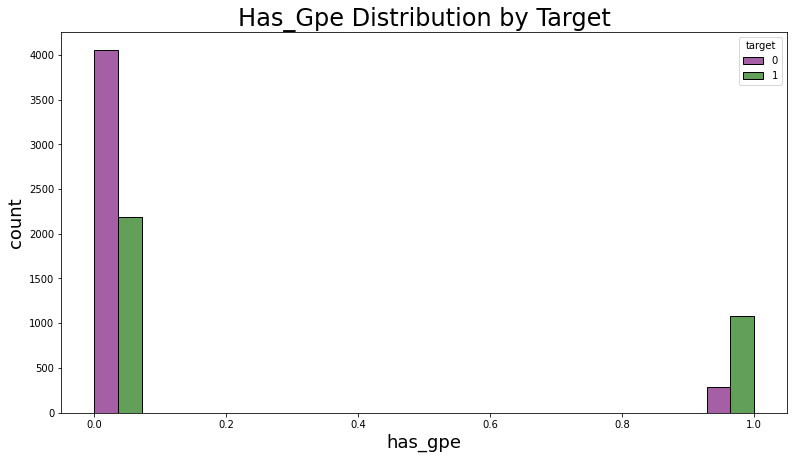

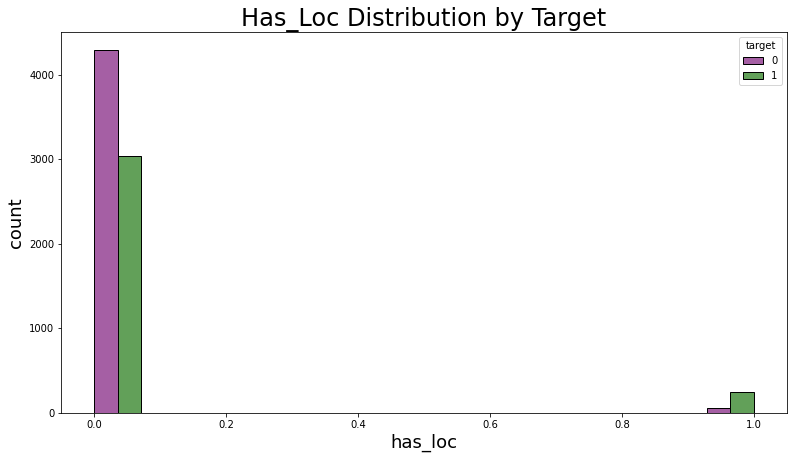

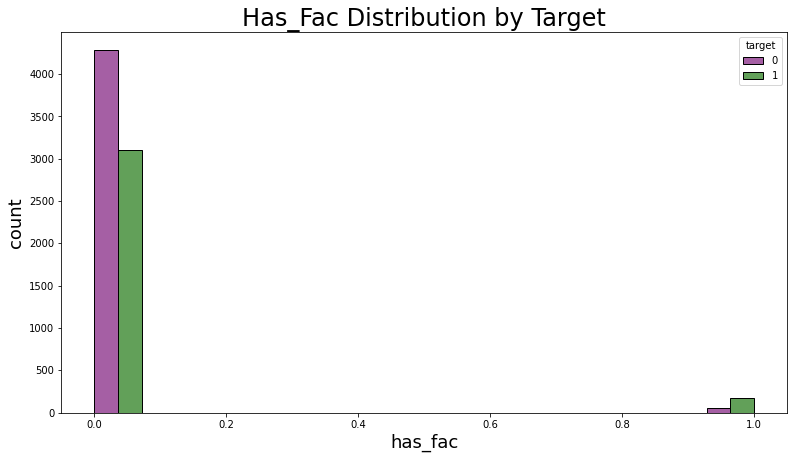

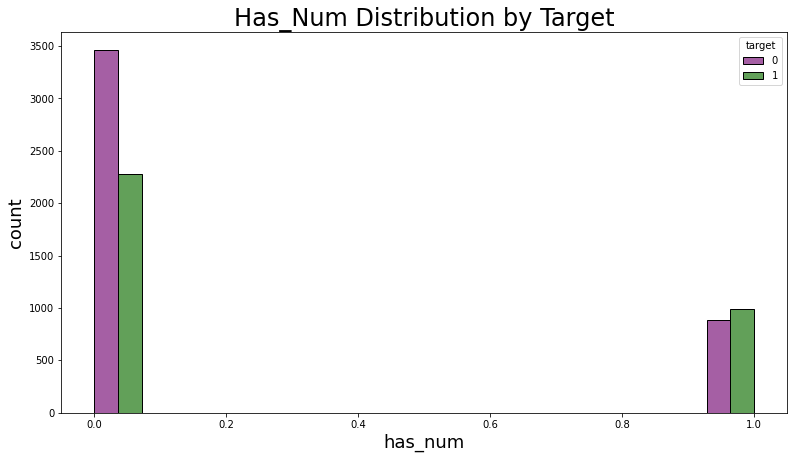

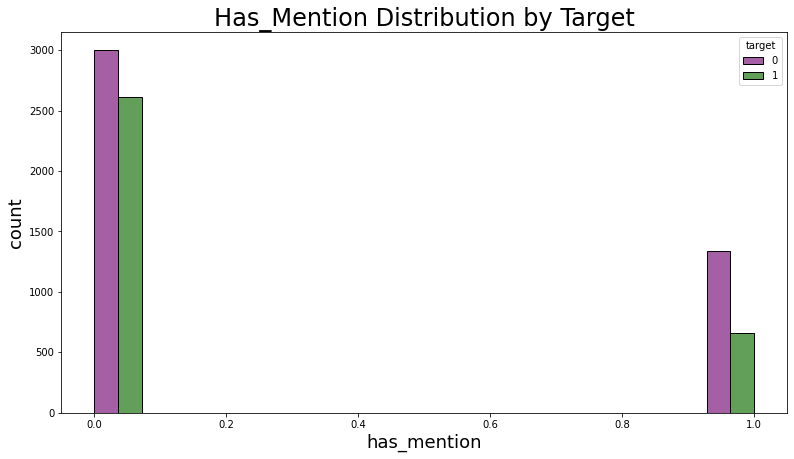

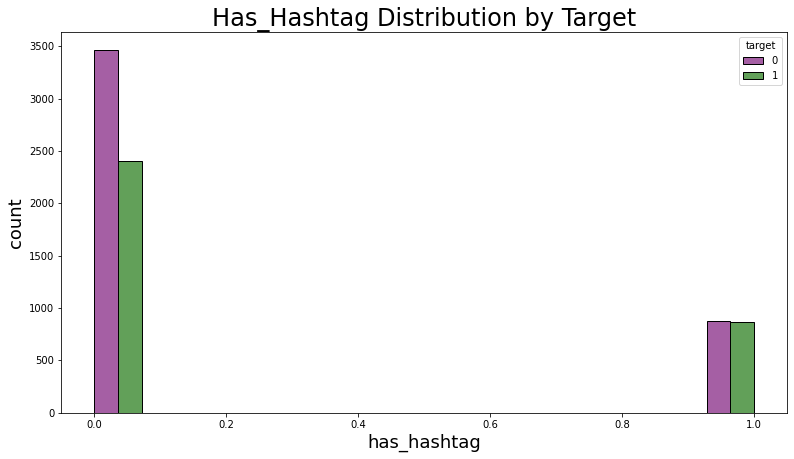

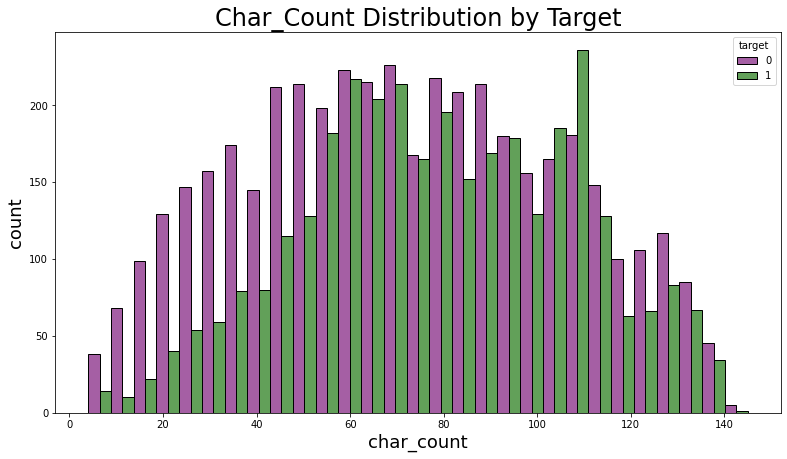

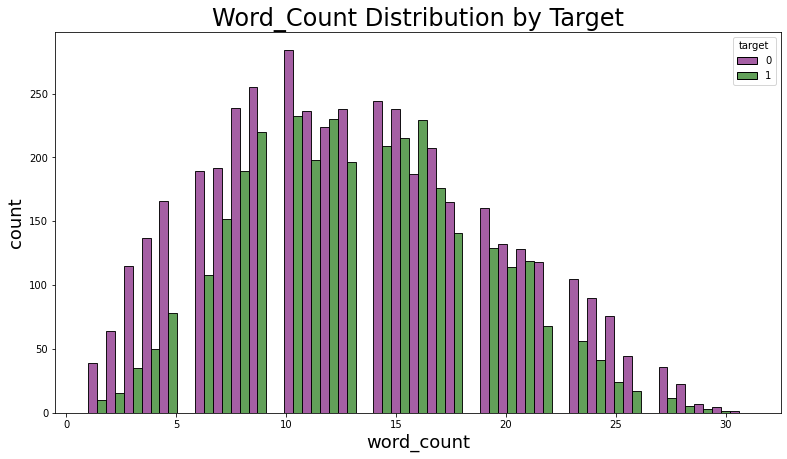

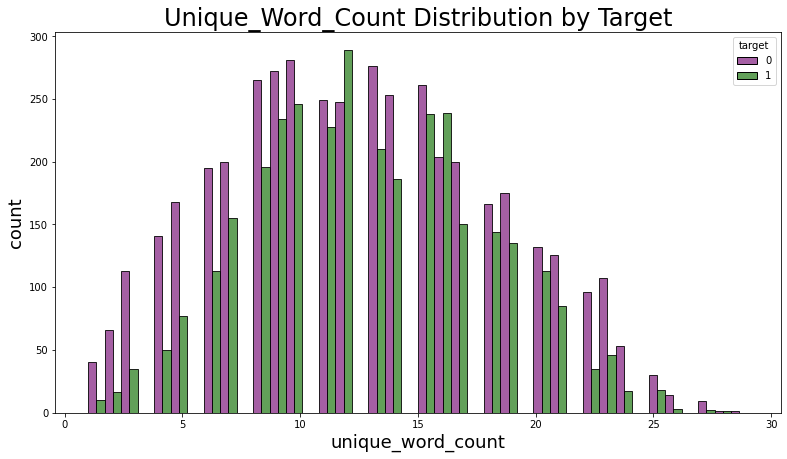

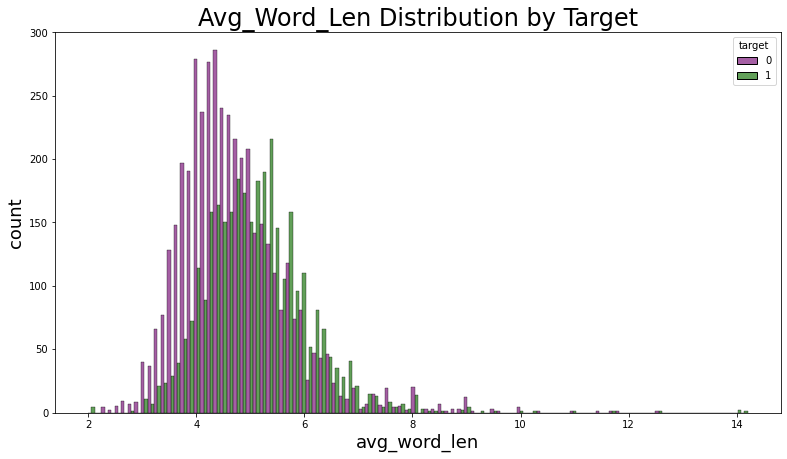

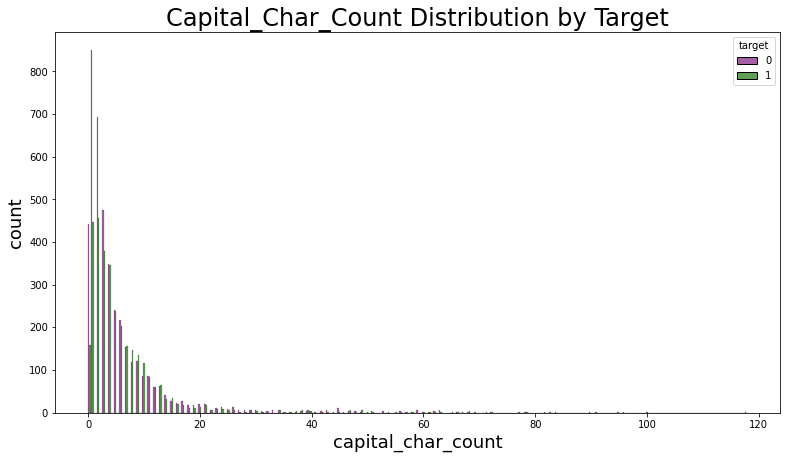

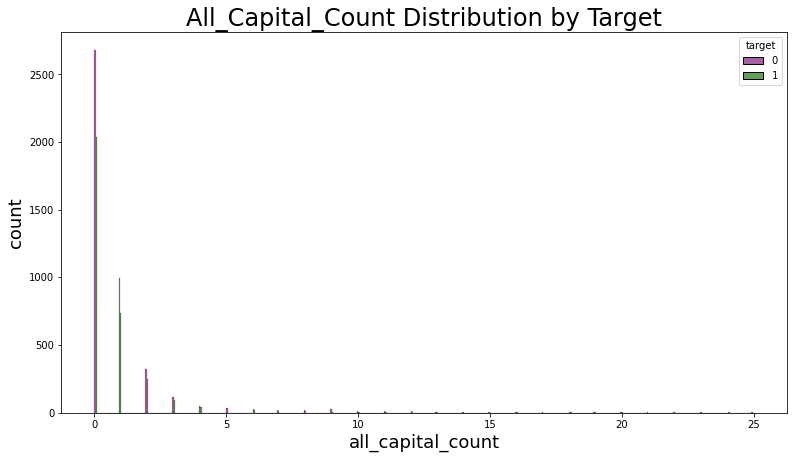

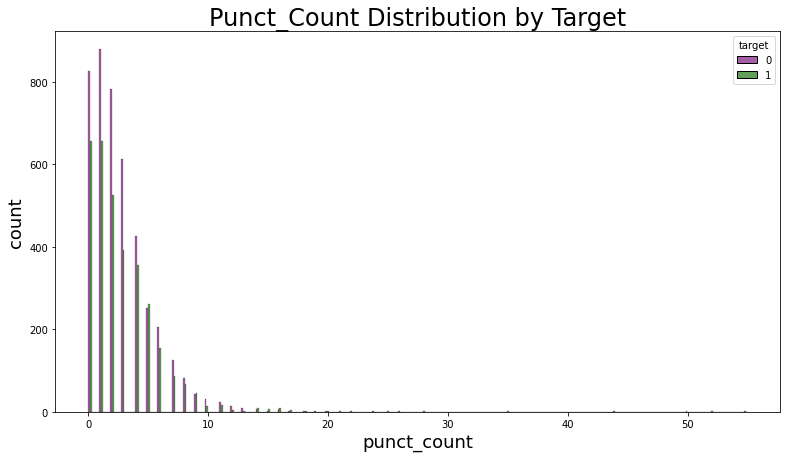

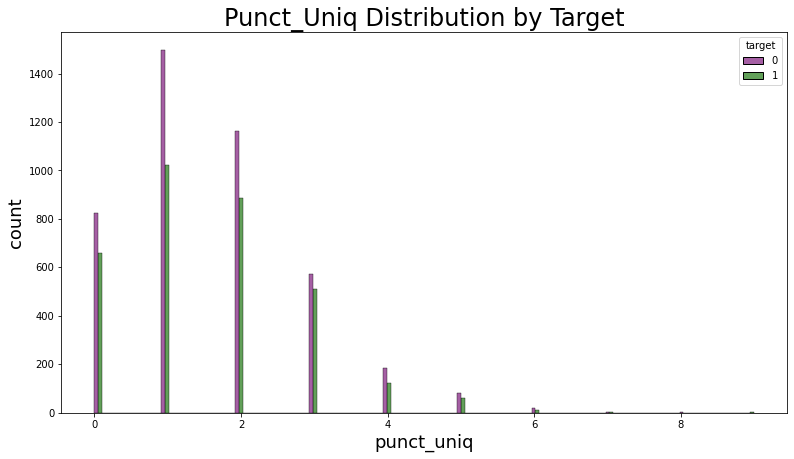

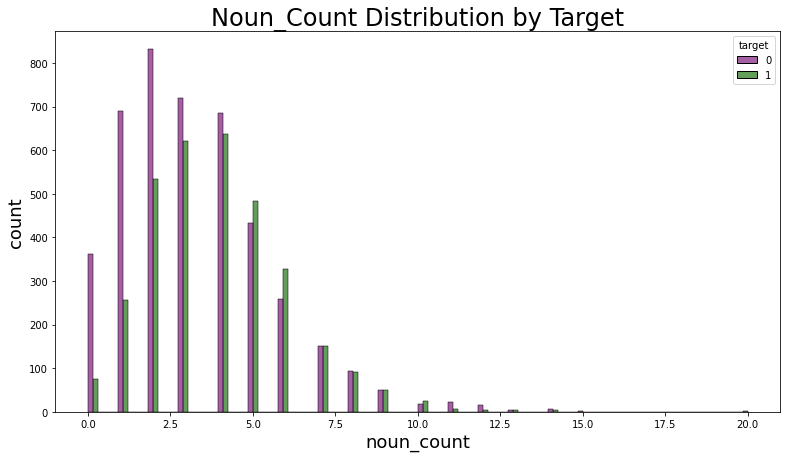

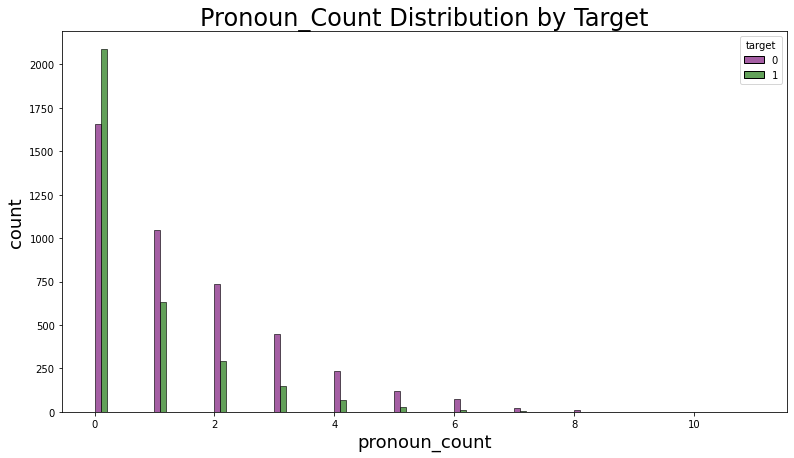

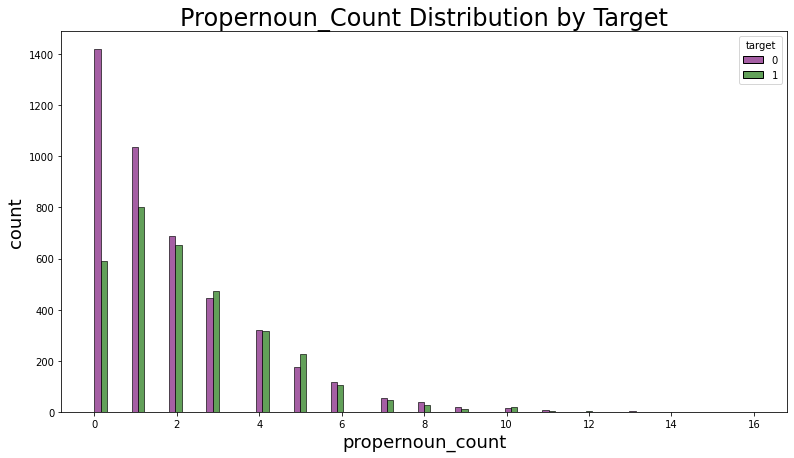

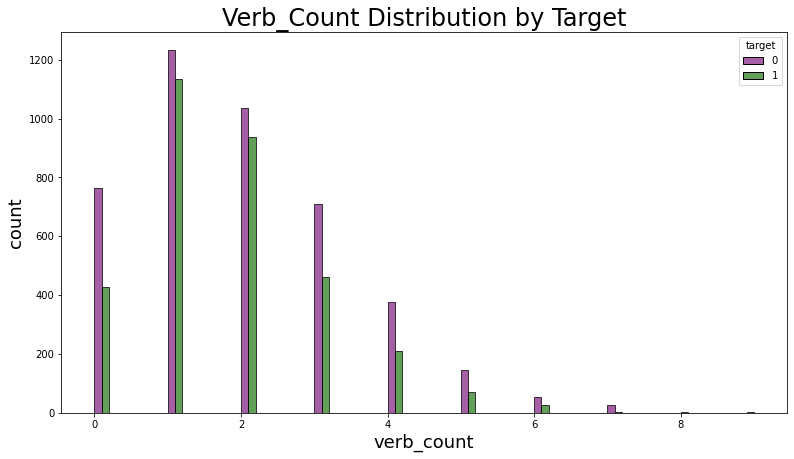

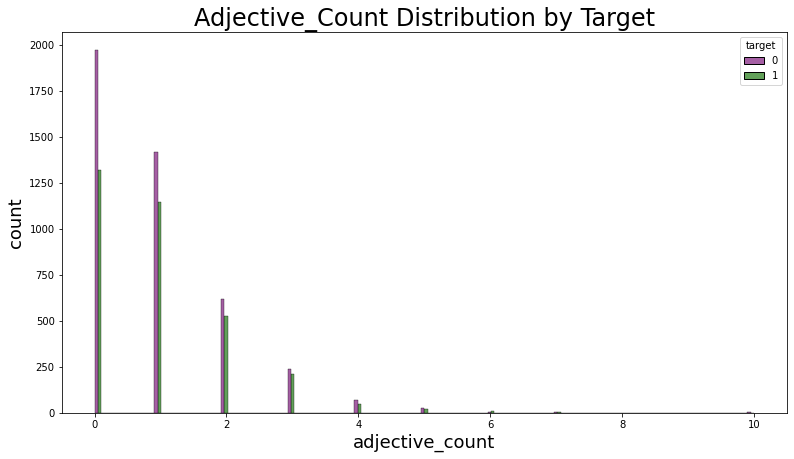

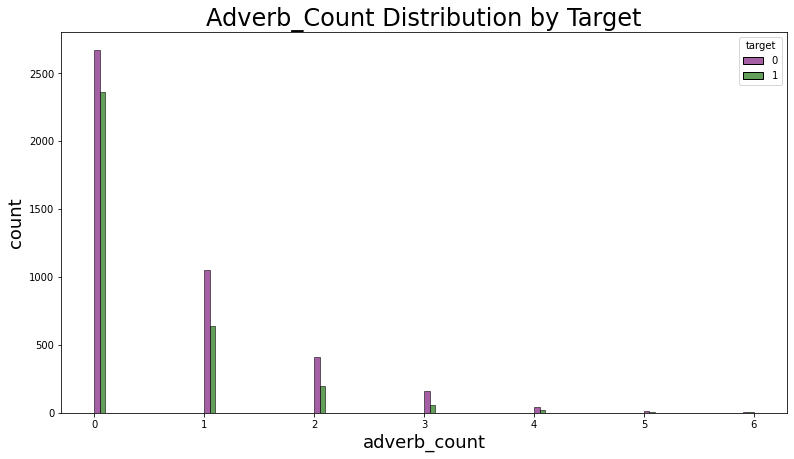

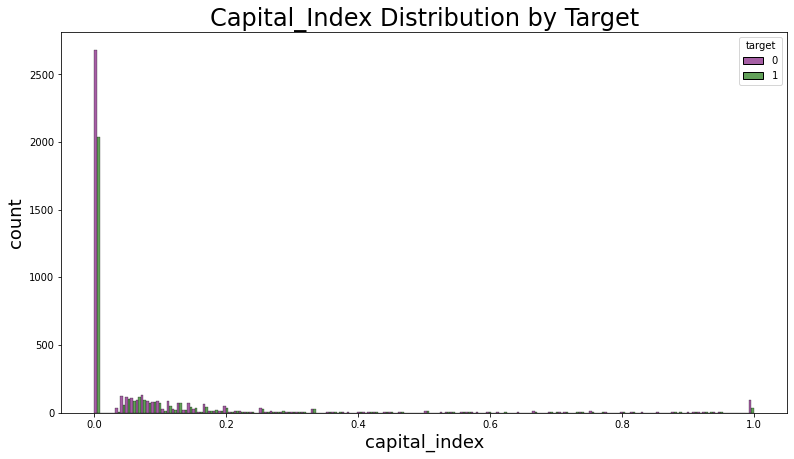

In [20]:
#define palette for plot
palette = ["#872A86", "#2E8121"]

#plot each feature distribution vs survival
sns.set_palette(palette=palette)
for col in feature_EDA.drop('target', axis=1).columns:
    fig, ax = plt.subplots(figsize=(13,7))
    sns.histplot(
        x=col,
        data=feature_EDA,
        hue='target',
        multiple='dodge'
    ).set_title(f'{col.title()} Distribution by Target', fontsize= 24)
    plt.xlabel(xlabel= col, fontsize=18)
    plt.ylabel(ylabel= 'count', fontsize=18)
    plt.show()

<span style='font-family:sabon;font-size:13pt;'> <b><u>results</u></b>: <br>
  <br>
  <b>Char Count(Tweet Length)</b>:<br> We see that shorter tweets tend to not be disaster related.<br> The disaster tweet trend seems to begin rising past 50 characters and experiences a sharp peak around 130 character.<br><br>
  <b>Word Count</b>:<br> We see a classic normal distribution with most tweets placed between 10 and 20 words, however the difference between disaster and non-disaster tweets is very small in this range.<br>
    Both tweets with less words and those with many words appear to be more common with non-disaster tweets.<br>
  <br>
  <b>Avg_word_len</b>: <br> 
    Interestingly we see that disaster tweets tend to have a higher average of word length! This could be an important feature for our model.<br><br>
  <b>Has_Url</b>: <br> 
    We see that more tweets that are tagged as disaster tweets contain URLs than non-disaster tweets.<br>
  <br>
  <b>Has Geopolitical Entity</b>: <br> We see that more tweets that are tagged as disaster tweets contain references to countries than non-disaster tweets. <br>
  <br>
  <b>Has Location or Facility</b>: <br> We see that more tweets that are tagged as disaster tweets contain specific locations than non-disaster tweets, however there are limited examples of tweets with specific locations in the training dataset.<br>
  <br>
     <b>Has Number</b>: <br> We don't see a big difference between disaster tweets and non-disaster tweet count when looking at the presence of numbers in a tweet.<br>
  <br>
      <b>Has Mention</b>: <br> We see that when tweets contain mentions they are more often than not, non-disaster tweets.<br>
  <br>
      <b>Has Hashtag</b>: <br> The presence of hashtags don't seem to imply the nature of the tweet in our case.<br>
  <br>
      <b>Punctuation Count</b>: <br> Interestingly the sweet spot for disaster tweets where they begin to diverge from non-disaster tweets is 5-7.<br>However most of them are still within the range of 0-3<br><br>
    <b>Noun Count</b>: <br> We see that disaster tweets tend to have a higher number of nouns.<br><br>
    <b>Pronoun Count</b>: <br> We see that disaster tweets tend to have less pronouns.<br><br>
    <b>Proper Noun Count</b>: <br> We see that disaster tweets tend to have more proper nouns.<br><br>
    <b>Capital Index</b>: <br> No clear trend here, but we see that most tweets that are all capital letters are usually not disaster tweets.
</span>

<a id='vector'></a>
<h2>8. WordCloud and TF-IDF Vectorizing</h2>

<span style='font-family:sabon;font-size:13pt;'>
    Up until this part we mostly did feature engineering to extract meaningful features from our textual data.<br>
    In this part we will actually interact directly with our textual data and turn the words themselves into features for our model!<br><br>
    For this task we use TF-IDF Vectorizing.<br><br>
    <b>What is TF-IDF?</b><br>
    TF-IDF or <b>term frequency-inverse document frequency</b> is a method or statistical measure we use to evaluate how relevant a word or set of words are to a document in a collection of documents.<br><br>
    Say what?<br><br>
    In other words, Term Frequency is the frequency in which a certain word appears in a document, like a tweet for example.<br>Inverse Document Frequency is a measure that tells us how rare a word is within our corpus of documents (all our tweets).<br>IDF is calculated by Log(Total # of documents)/ # documents containing the word).<br>
    Multiplying IDF by TF gives us the TF-IDF measure.<br><br>
    In simple terms, the lower a words TF-IDF score is, the more common it is.<br>
    The higher the TF-IDF score is, the rarer the word is.<br>
    <b>This vector will help our model determine meaningful connections between words or phrases TF-IDF scores and their relevance to the target variable.</b>
</span>

<a id='vector_cloud'></a>
<h3>8.1. Word Clouding</h3>

<span style='font-family:sabon;font-size:13pt;'>
    Before we vectorize our tweets, we want to make sure that we remove some very common words also known as stopwords.<br>
    We use a premade list from the nltk module, however we will modify it for our use case, as some of the words in the stopwords list could be critical in our case.<br>
    Once we have our stopwords, we will plot a wordcloud and see if there are any other stopwords we want to add.
</span>

In [21]:
#remove some words from stop word list
my_stopwords = ENGLISH_STOP_WORDS.difference(
    [
        'fire',
        'call', 
        'cry', 
        'serious', 
        'please', 
        'nobody', 
        'not',
        'noone',
        'none',
        'no',
        'many',
        'one',
        'although',
        'again',
        'yourselves'
    ])

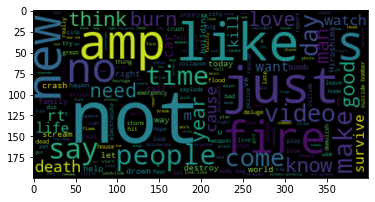

In [22]:
#join together both datasets to see a proper depiction of the most common words
concat_tweets = pd.concat([train_tweets[['lem_text']], test_tweets[['lem_text']]])

#generate wordcloud using our stopword list
tweet_cloud = WordCloud(
    background_color='black',
    stopwords= my_stopwords)\
        .generate(' '.join(concat_tweets['lem_text']))

#display wordcloud
plt.imshow(tweet_cloud, interpolation='bilinear')
plt.show()

<span style='font-family:sabon;font-size:13pt;'>
    We see a few words and letters which are artifacts of the text processing.<br>
    Most of these will be removed when we use the vectorizer, but for good measure let's get rid of some of these right now!
</span>

In [23]:
#update stopword list
my_stopwords = my_stopwords.union(
    ['RT','rt', 'amp', 'go', 'will','U', 's', 'm', 've', 't', 'g', 'w']
)

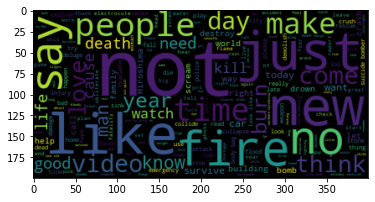

In [24]:
#generate wordcloud using our updated stopword list
tweet_cloud = WordCloud(
    background_color='black',
    stopwords= my_stopwords)\
        .generate(' '.join(concat_tweets['lem_text']))

#display wordcloud
plt.imshow(tweet_cloud, interpolation='bilinear')
plt.show()

<span style='font-family:sabon;font-size:13pt;'>
    Looks a little better!<br>
    We'll keep the stopword list with us for when we use the TF-IDF vectorizer in the next step.
</span>

<a id='vector_tfidf'></a>
<h3>8.2. Transforming Tweets to TF-IDF Vectors</h3>

<span style='font-family:sabon;font-size:13pt;'>
    Finally, our last step of preparation!<br>
    Here We will pass our stopwords list to the vectorizer so that it can ignore them.<br>
    We are also setting the vectorizer to ignore words or phrases that occur in less than 5 documents, as well as words which are too common to be relevant, which appear in over 70% of the documents.<br>
    Finally, we will break apart the tweets into an n-gram range of (1,2).<br><br>
    What does that mean?<br>
    This means we will be calculating relevance for singular words, as well as combinations of each two consecutive words in each tweet.<br>
    This is important because there is a critical difference between "forest" and "forest fire" in our case!<br>
    We could even use a range of 3 words or more, but we want to make sure our model remains fairly generalized and doesn't overfit the training data with very specific phrases.
</span>

In [25]:
#define tfidf vectorizer
tfidfconverter = TfidfVectorizer(
    min_df=5,
    max_df=0.7, 
    stop_words=my_stopwords,
    ngram_range=(1,2)
)  

#fit and transform the tweets
X = tfidfconverter.fit_transform(train_tweets['lem_text']).toarray()

#create dataframe using the resulting vector array with all the feature names
x_df = pd.DataFrame(X,columns = tfidfconverter.get_feature_names_out())

<span style='font-family:sabon;font-size:13pt;'>
    Down below you can see the resulting dataframe with a whoping 3106 features!<br>
    The values represent the TF-IDF score.<br><br>
</span>

In [26]:
x_df.sample(random_state=42)

,aba,aba woman,abandon,abandon aircraft,abc,abc news,ablaze,able,absolutely,abstorm,...,york times,young,youth,youth save,youtube,yr,yyc,zionist,zombie,zone
2644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<span style='font-family:sabon;font-size:13pt;'>
    Finally, we will join the features we've created in the past steps to the TFIDF feature dataframe.<br>
    This Concludes our preparation of the data, and we can proceed to choose a model for prediction!
</span>

In [27]:
#define full data for training
X_df_fullfeat = x_df.join(
    train_tweets.drop([
        'keyword',
        'location',
        'text',
        'target',
        'text_nlp',
        'lem_text', 
        'id'
    ], axis=1)
)

#define target variable array for training
y_train_data = train_tweets['target']

<a id='ML'></a>
<h2>9. Choosing Our Machine Learning Model</h2>

<span style='font-family:sabon;font-size:13pt;'>
    All we have left to do is choose a machine learning model appropriate for the job and then perform our prediction!<br>
    For this task of predicting a binary distinction between disaster and non-disaster tweet we will use a classification model.<br><br>
    We will be testing multiple models using our predefined function and choose one or two models to go forward with, how exciting is that??
</span>

Model: XGBClassifier

Accuracy: 0.80
Percision: 0.82
Recall: 0.69
F1 Score: 0.75
ROC AUC: 0.85


,score
avg_word_len,83.0
char_count,61.0
capital_char_count,46.0
punct_count,37.0
propernoun_count,32.0


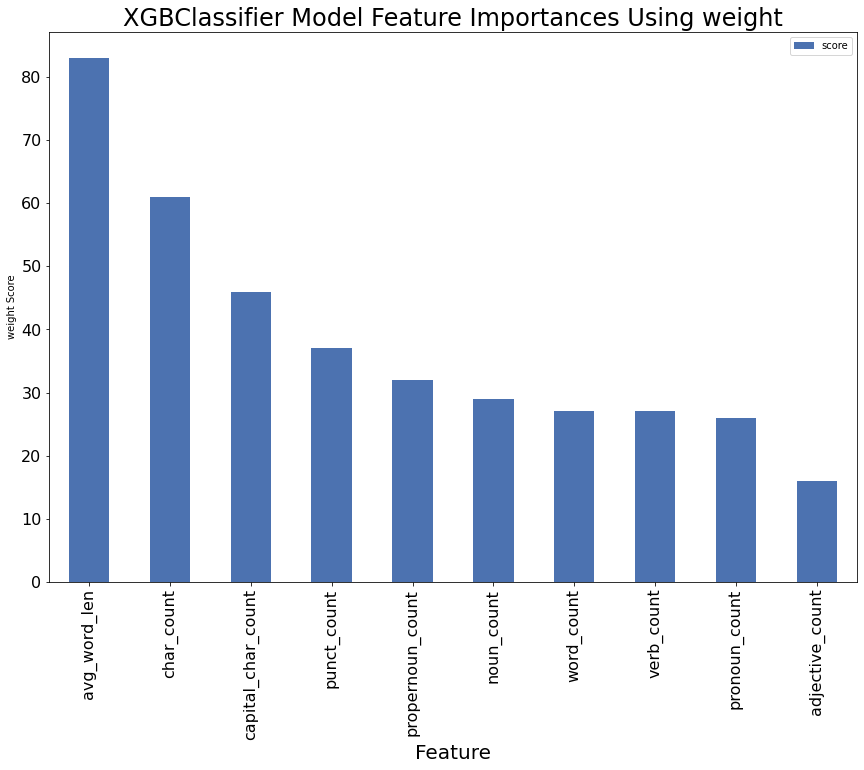

Model: RandomForestClassifier

Accuracy: 0.79
Percision: 0.85
Recall: 0.63
F1 Score: 0.72
ROC AUC: 0.85


,importance
has_gpe,0.041703
avg_word_len,0.032498
pronoun_count,0.024882
char_count,0.023482
noun_count,0.020044


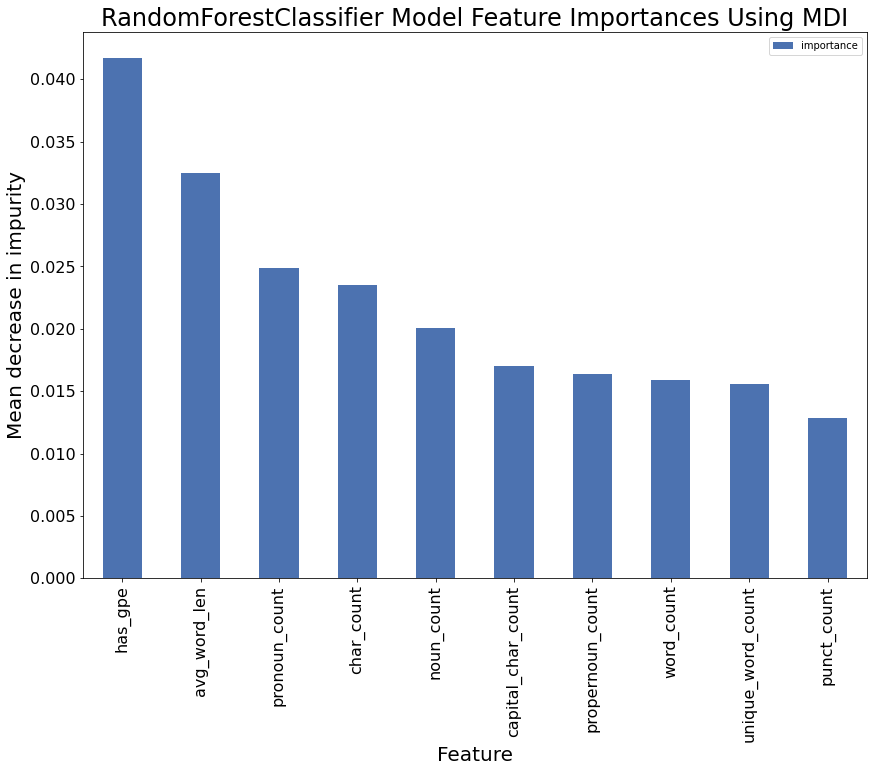

Model: GradientBoostingClassifier

Accuracy: 0.78
Percision: 0.81
Recall: 0.62
F1 Score: 0.70
ROC AUC: 0.83


,importance
has_gpe,0.270961
pronoun_count,0.062796
avg_word_len,0.054883
has_loc,0.053098
has_url,0.039264


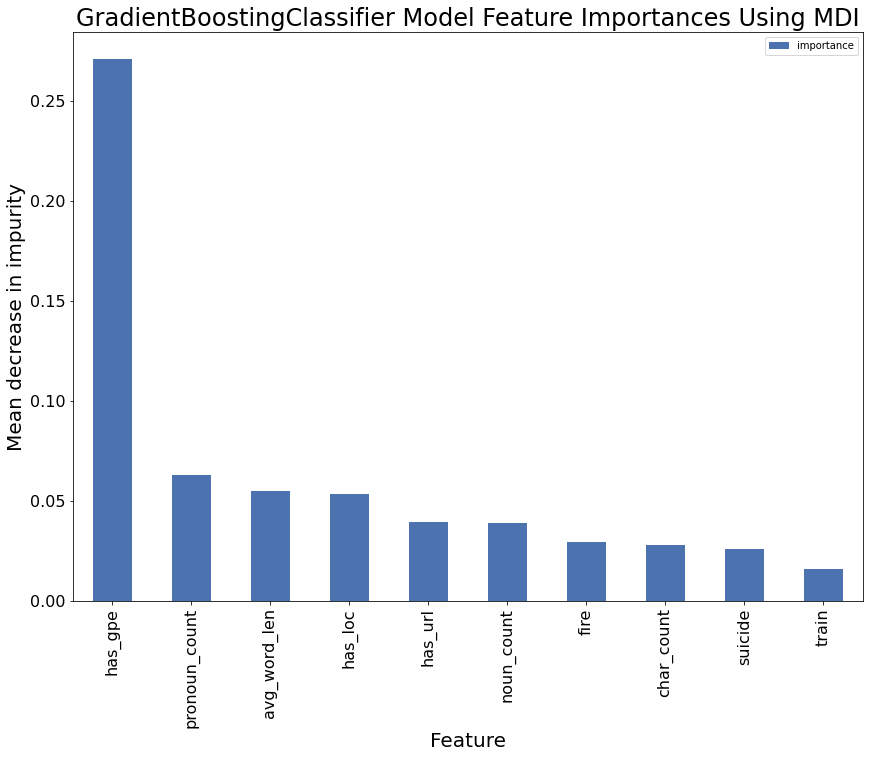

Model: DecisionTreeClassifier

Accuracy: 0.70
Percision: 0.66
Recall: 0.61
F1 Score: 0.63
ROC AUC: 0.69


,importance
has_gpe,0.114690
avg_word_len,0.042867
has_url,0.033284
capital_char_count,0.027327
char_count,0.025322


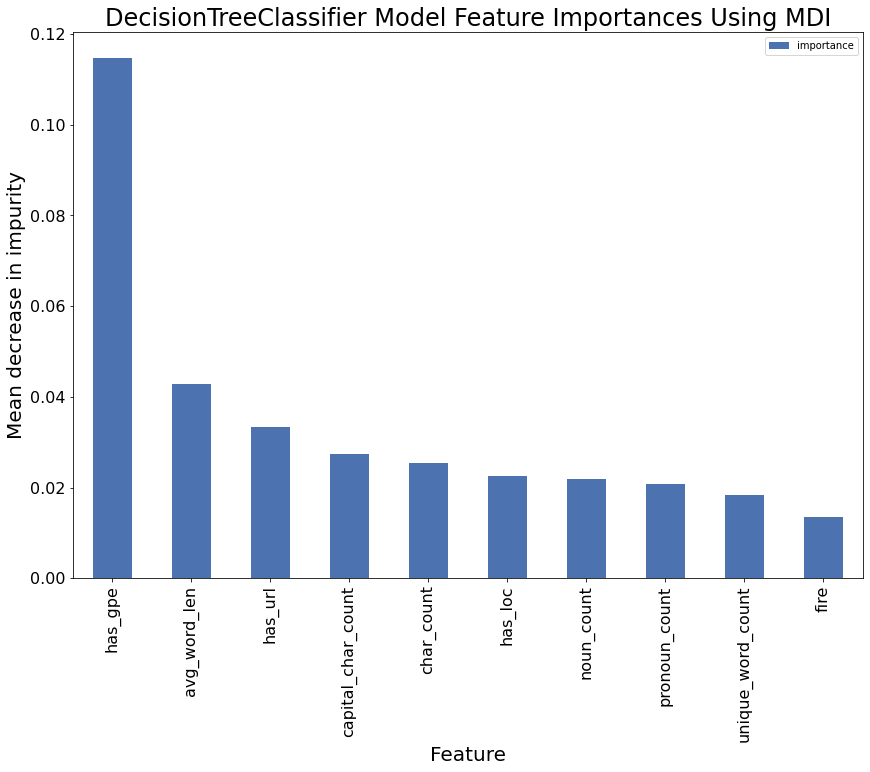

In [28]:
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(
                                                        X_df_fullfeat,
                                                        y_train_data,
                                                        test_size=0.25,
                                                        random_state=42
                                                    )
#define models
models= [
    XGBClassifier(random_state =42),
    RandomForestClassifier(random_state = 42),
    GradientBoostingClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

#define feature names for visualization
X_columns = X_df_fullfeat.columns 

#scale data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#test models with training data
classification_prediction(
    models,
    X_columns,
    X_train_st,
    X_test_st,
    y_train,
    y_test,
    proba_metrics= True
)


<span style='font-family:sabon;font-size:13pt;'>
    For this case, we will mostly use the F1 score to determine our best candidates.<br>
    The F1 score combines the precision and recall scores (which means it incorporates the rates of false positives and false negatives in our results) and has the range of [0,1] with 1 being the best score possible.<br><br>
    We have two candidates who perform rather well, Random Forest Classifier(henceforth RFC), and XGBClassifier (henceforth XGBC).<br>
    Both have the highest f1 score, though RFC's recall is a slightly lower.<br><br>
    If we look at the visualizations for these two we can learn a little bit about which features the model decided were the most important for the classification:<br>
    <ul>
    <li><b>avg_word_len</b>: we saw important differences with this feature when visualizing it, and sure enough it seems to be rather important, being 1st place feature in XGBC and 2nd place in RFC in deciding classification of a tweet.</li>
        <li><b>has_gpe</b>: We saw this one correlating with the target variable in our heatmap, RFC puts this one in 1st place.</li>
        <li><b>Honorable mentions</b>: char_count, pronoun_count, noun_count and word_count all appear in the top 10 features of both models.</li>
    </ul>
    We will take both candidates forward and try to optimize them before applying them to the prediction data.
</span>

<a id='cv'></a>
<h2>10. Hyperparameter Optimization and Gridsearch</h2>

<span style='font-family:sabon;font-size:13pt;'>
    Machine learning models have many different parameters that could be tweaked and can affect the resulting predictions and model performance greatly.<br>
    In order to make full use of our two models, we will perform optimization on their parameters, also known as hyperparamater optimization.<br>
    A popular tool that helps us do this is Gridsearch Cross Validation and Randomized Search Cross Validation.<br><br>
    We will start by creating a random grid of parameters and feeding it into the randomizedsearchCV function, which will check the different combinations of parameters, eventually deciding on the best one.<br><br>
    <b>Note: The resulting parameters may be slightly different with each run of the notebook. The parameter tweaking in each iteration and the resulting accuracy of the models relies on the original run of the notebook</b>
</span>

<a id='cv_rfc'></a>
<h3>10.1. RFC Randomized Search CV</h3>

In [29]:
#set random state
random_state = [42]
#produce list of n trees to use
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 4)]

#set max features parameter
max_features = ['auto']

#set maximum depth list, including None
max_depth = [int(x) for x in np.linspace(5, 100, num = 4)]
max_depth.append(None)

#set minimum samples split
min_samples_split = [3, 5, 9]

#set minimum samples at each leaf node
min_samples_leaf = [1, 2, 3]

#set method of selecting samples for training each tree
bootstrap = [False]

#generate random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state' : random_state
              }
#print resulting grid
random_grid

{'n_estimators': [200, 533, 866, 1200],
 'max_features': ['auto'],
 'max_depth': [5, 36, 68, 100, None],
 'min_samples_split': [3, 5, 9],
 'min_samples_leaf': [1, 2, 3],
 'bootstrap': [False],
 'random_state': [42]}

In [30]:
#define base model
rf = RandomForestClassifier(random_state= 42)

#search 150 combinations, using 3 fold cross validation
rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 50,
    scoring = 'f1',
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1
)

#train the model using the chosen parameters
rf_random.fit(X_train_st, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [5, 36, 68, 100, None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [3, 5, 9],
                                        'n_estimators': [200, 533, 866, 1200],
                                        'random_state': [42]},
                   random_state=42, scoring='f1', verbose=2)

<span style='font-family:sabon;font-size:13pt;'>
    And here are our resulting best parameters:
</span>

In [31]:
#show best parameters
rf_random.best_params_

{'random_state': 42,
 'n_estimators': 866,
 'min_samples_split': 9,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

<a id='cv_rfc_comp'></a>
<h4>10.1.1. Updated Model vs Original Model</h4>

Model: RandomForestClassifier

Accuracy: 0.79
Percision: 0.85
Recall: 0.63
F1 Score: 0.72
ROC AUC: 0.85


,importance
has_gpe,0.041703
avg_word_len,0.032498
pronoun_count,0.024882
char_count,0.023482
noun_count,0.020044


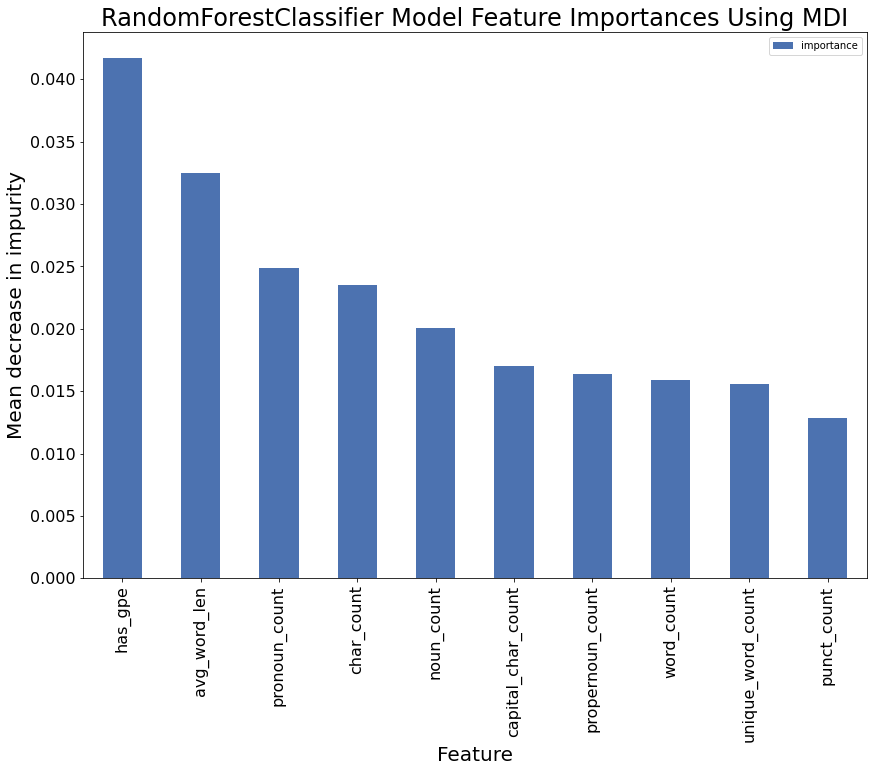

Model: RandomForestClassifier

Accuracy: 0.79
Percision: 0.85
Recall: 0.63
F1 Score: 0.72
ROC AUC: 0.85


,importance
has_gpe,0.045654
avg_word_len,0.031160
pronoun_count,0.024698
char_count,0.018232
noun_count,0.017847


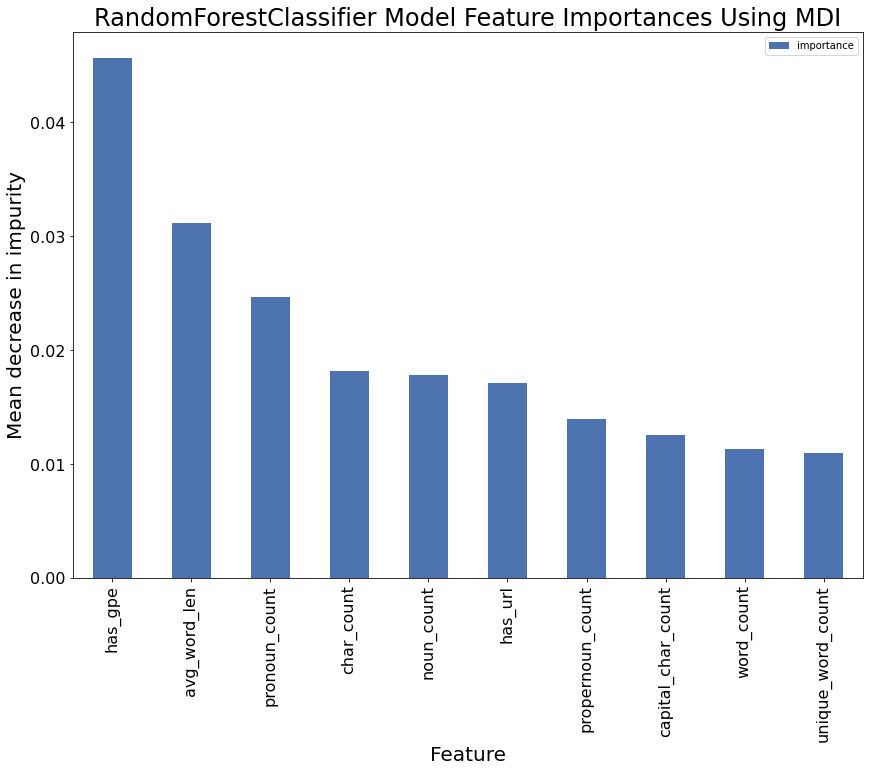

In [32]:
#Base model results
base_model = RandomForestClassifier(random_state= 42)
best_model = rf_random.best_estimator_

classification_prediction([base_model, best_model], X_columns, X_train_st, X_test_st, y_train, y_test, proba_metrics= True)

<a id='cv_rfc_it1'></a>
<h4>10.1.2. 2nd Iteration</h4>

<span style='font-family:sabon;font-size:13pt;'>
    We'll perform one more iteration to try to find the sweet spot for the model.
</span>

In [33]:
param_grid = rf_random.best_params_

#defining new testing parameters based on results
param_grid['n_estimators'] = [700, 850, 950]
param_grid['max_features'] = ['auto']
param_grid['max_depth'] = [45, 55, 74, 85]
param_grid['min_samples_split'] = [4,5,6]
param_grid['min_samples_leaf'] = [1]
param_grid['bootstrap'] = [False]
param_grid['random_state'] = [42]

In [34]:
# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator = rf, 
    scoring= 'f1',
    param_grid = param_grid, 
    cv = 3,
    n_jobs = -1, 
    verbose = 3
)

# Fit the grid search to the data
grid_search.fit(X_train_st, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'bootstrap': False,
 'max_depth': 85,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 850,
 'random_state': 42}

<span style='font-family:sabon;font-size:13pt;'>
    It seems that the parameters we got after optimization are similar to our initial grid results.<br>
    In this case we'll take the parameters we got and roll with them onwards.
</span>


Model: RandomForestClassifier

Accuracy: 0.79
Percision: 0.85
Recall: 0.63
F1 Score: 0.72
ROC AUC: 0.85


,importance
has_gpe,0.044476
avg_word_len,0.032694
pronoun_count,0.025135
char_count,0.019677
noun_count,0.019456


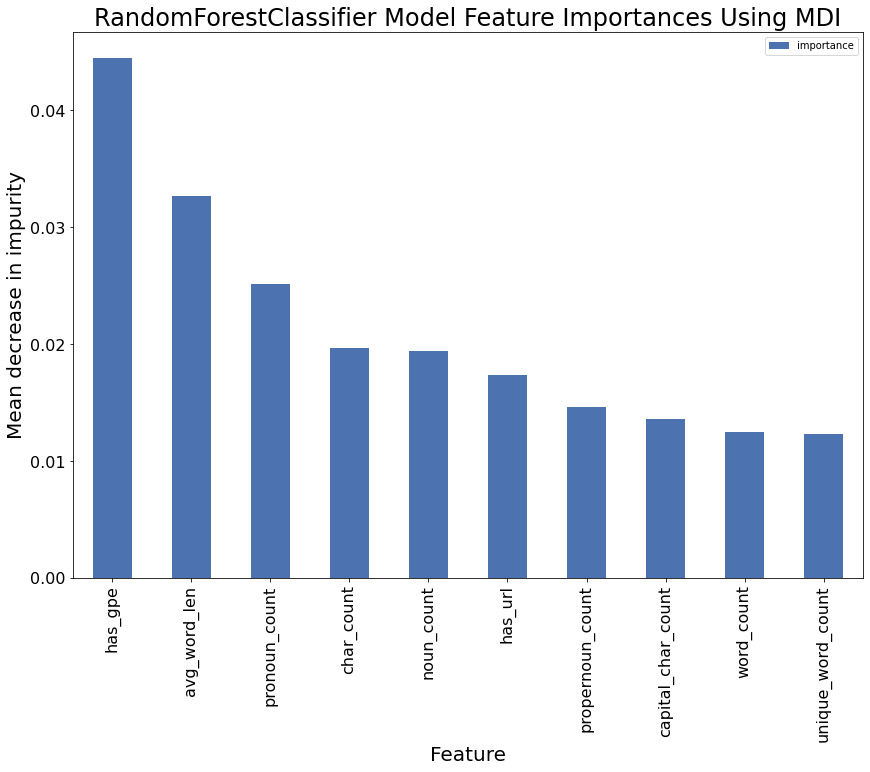

In [35]:
#define model with chosen parameters
rf_clf = grid_search.best_estimator_

#train model and show performance and feature importance
classification_prediction(
    [rf_clf],
    X_columns,
    X_train_st,
    X_test_st, 
    y_train, 
    y_test, 
    proba_metrics= True
)

<a id='cv_xgb'></a>
<h3>10.2. XGBC Randomized Search CV</h3>

In [36]:
#set random state
random_state = [42]
#eta to use
eta = [0.15, 0.20, 0.25, 0.30, 0.4]

#set maximum depth
max_depth = [3, 6, 8, 12]

#set gamma
gamma = [0, 0.1, 0.2 , 0.3, 0.4]

#set colsample_bytree
colsample_bytree = [0.3, 0.5, 0.7, 1]

#set min child weight
min_child_weight  = [1, 2, 4]

#set subsample
subsample  = [0.5, 0.75, 1]

#generate random grid
random_grid = {'eta': eta,
               'max_depth': max_depth,
               'gamma': gamma,
               'colsample_bytree': colsample_bytree,
               'min_child_weight': min_child_weight,
               'random_state' : random_state
              }
#print resulting grid
random_grid

{'eta': [0.15, 0.2, 0.25, 0.3, 0.4],
 'max_depth': [3, 6, 8, 12],
 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
 'colsample_bytree': [0.3, 0.5, 0.7, 1],
 'min_child_weight': [1, 2, 4],
 'random_state': [42]}

In [ ]:
#set base model
xg_clf = XGBClassifier(random_state= 42)

#search 150 combinations, using 3 fold cross validation
xg_random = RandomizedSearchCV(
    estimator = xg_clf,
    param_distributions = random_grid,
    n_iter = 50,
    cv = 3,
    verbose=1,
    scoring = 'f1',
    random_state=42,
    n_jobs = -1
)

#train the model using the chosen parameters
xg_random.fit(X_train_st, y_train)

<span style='font-family:sabon;font-size:13pt;'>
    And here are our resulting best parameters:
</span>

In [38]:
#show best parameters
xg_random.best_params_

{'random_state': 42,
 'min_child_weight': 1,
 'max_depth': 6,
 'gamma': 0,
 'eta': 0.4,
 'colsample_bytree': 0.3}

<a id='cv_xg_it1'></a>
<h4>10.2.1. 2nd Iteration</h4>

In [39]:
#update parameter grid
param_grid = xg_random.best_params_

In [40]:
#testing
#defining new testing parameters based on results
param_grid['min_child_weight'] = [1]
param_grid['max_depth'] = [5,6,7]
param_grid['eta'] = [0.38, 0.42, 0.44]
param_grid['colsample_bytree'] = [0.1,0.2, 0.3, 0.4]
param_grid['gamma'] = [0]
param_grid['random_state'] = [42]

In [ ]:
# Create a base model
xg_clf = XGBClassifier(random_state = 42)
1
# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator = xg_clf,
    param_grid = param_grid,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 3
)

# Fit the grid search to the data
grid_search.fit(X_train_st, y_train)

In [42]:
grid_search.best_params_ 

{'colsample_bytree': 0.1,
 'eta': 0.44,
 'gamma': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'random_state': 42}

<a id='cv_xg_it2'></a>
<h4>10.2.2. 3rd Iteration</h4>

In [43]:
#defining new testing parameters based on results
param_grid['min_child_weight'] = [1]
param_grid['max_depth'] = [7]
param_grid['eta'] = [0.43, 0.44, 0.46, 0.48]
param_grid['colsample_bytree'] = [0.1]
param_grid['gamma'] = [0]
param_grid['random_state'] = [42]

In [ ]:
# Create a base model
xg_clf = XGBClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator = xg_clf,
    param_grid = param_grid,
    scoring='roc_auc',
    cv = 8,
    n_jobs = -1,
    verbose = 1
)

# Fit the grid search to the data
grid_search.fit(X_train_st, y_train)

<span style='font-family:sabon;font-size:13pt;'>
    These are the final main parameters we will be using:
</span>


In [45]:
grid_search.best_params_ 

{'colsample_bytree': 0.1,
 'eta': 0.48,
 'gamma': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'random_state': 42}

<a id='cv_final'></a>
<h3>10.3. Final Models Showcase</h3>

<span style='font-family:sabon;font-size:13pt;'>
    Finally we have our two models optimized, trained and ready to go!
</span>

Model: XGBClassifier

Accuracy: 0.80
Percision: 0.82
Recall: 0.69
F1 Score: 0.75
ROC AUC: 0.85


,score
avg_word_len,83.0
char_count,61.0
capital_char_count,46.0
punct_count,37.0
propernoun_count,32.0


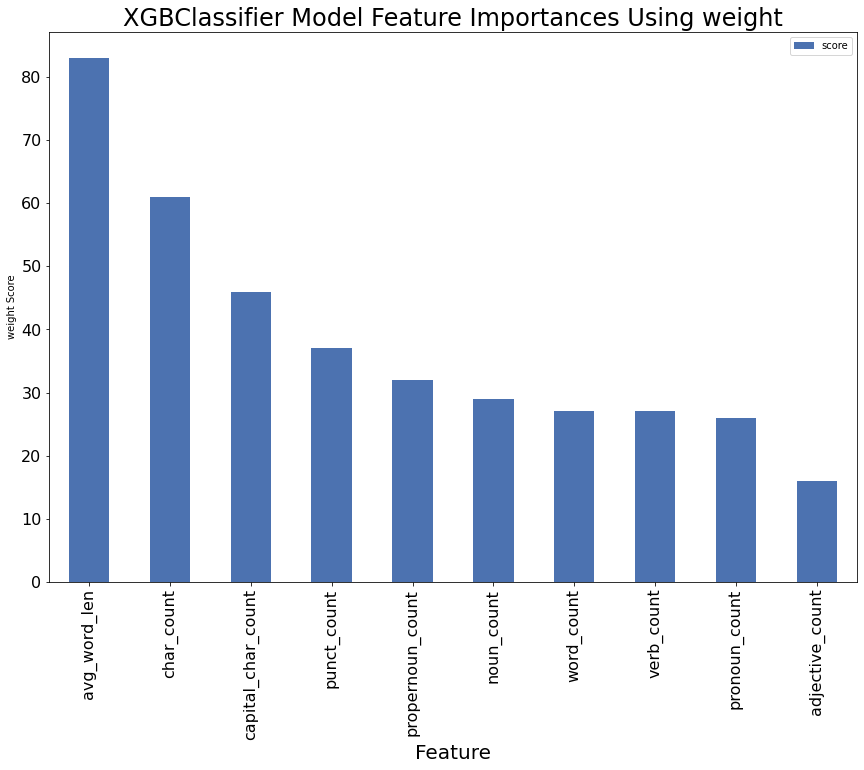

Model: RandomForestClassifier

Accuracy: 0.79
Percision: 0.85
Recall: 0.63
F1 Score: 0.72
ROC AUC: 0.85


,importance
has_gpe,0.044476
avg_word_len,0.032694
pronoun_count,0.025135
char_count,0.019677
noun_count,0.019456


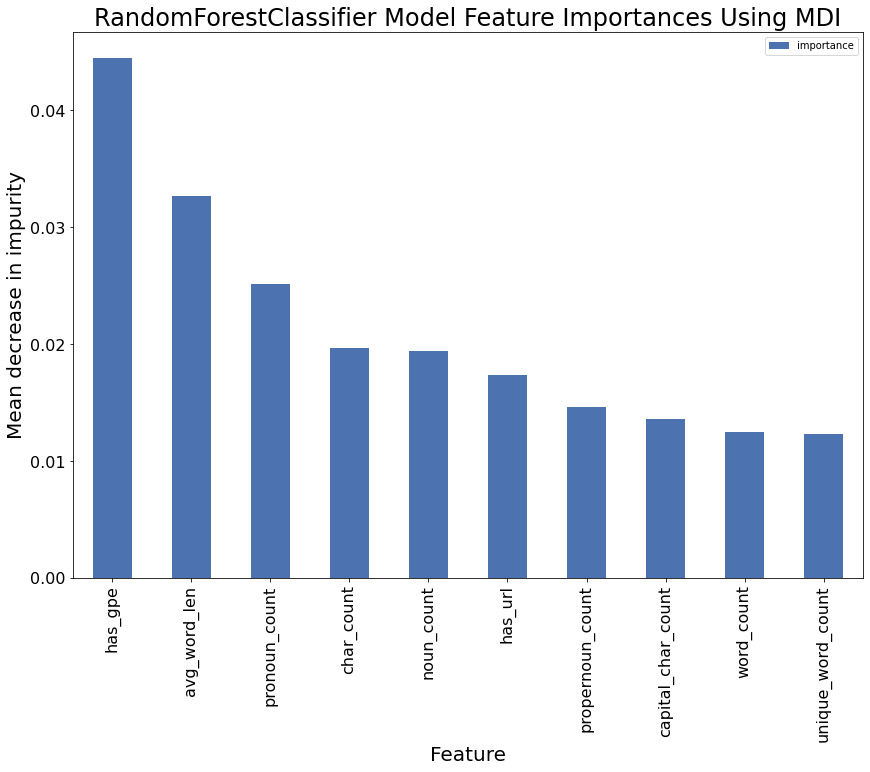

In [46]:
#train and show final models
classification_prediction(
    [xg_clf, rf_clf],
    X_df_fullfeat.columns,
    X_train_st, 
    X_test_st, 
    y_train,
    y_test,
    proba_metrics=True
)

<a id='predict'></a>
<h2>11. Predict Disaster Tweets</h2>

<span style='font-family:sabon;font-size:13pt;'>
    In order to predict the class of our unseen data, we will first transform it using the same TFIDF vectorizer we used for the train data, and in this way we will only get features made of words from our main training set (words from the unseen data set that don't exist in the training set don't mean anything to our model!).<br><br>
</span>

In [47]:
#create vector array from unseen tweet data
tweet_predict_vector = tfidfconverter.transform(test_tweets['lem_text']).toarray()

#create dataframe from vector array and feature names
y_df = pd.DataFrame(tweet_predict_vector ,columns = tfidfconverter.get_feature_names_out())

#show sample of data
y_df.sample()

,aba,aba woman,abandon,abandon aircraft,abc,abc news,ablaze,able,absolutely,abstorm,...,york times,young,youth,youth save,youtube,yr,yyc,zionist,zombie,zone
1702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<span style='font-family:sabon;font-size:13pt;'>
    Let's not forget our features which we worked so hard on creating!<br>
    Luckily we have been making the same changes to the unseen data as we have to the train data, so all the features are already calculated.<br>
    All we have to do is join them to the data.
</span>

In [48]:
#join relevant data to the prediction dataframe
y_df_fullfeat = y_df.join(test_tweets.drop(['keyword','location','text','text_nlp','lem_text', 'id'], axis=1))

<span style='font-family:sabon;font-size:13pt;'>
    Prediction time!
</span>

In [49]:
#scale new data with our scaler
new_data_predict = scaler.transform(y_df_fullfeat)

#predict with random forest
rf_pred = rf_clf.predict(new_data_predict)

#predict with xgboost
xg_pred = xg_clf.predict(new_data_predict)

In [50]:
#produce submission with rf model
test_tweets['target'] = rf_pred
test_tweets[['id','target']].to_csv('rf_submission.csv', index=False)

#produce submission with XGB model
test_tweets['target'] = xg_pred
test_tweets[['id','target']].to_csv('xg_submission.csv', index=False)


<a id='conc'></a>
<h2>12. Results and Conclusions</h2>

<span style='font-family:sabon;font-size:13pt;'>
    We got our hands on tweet data and were tasked with differentiating between disaster tweets and non-disaster tweets.<br>
    To solve this case, we cleaned and prepared the data for language processing, extracted meaningful features from the text of each tweet and used word vectorization techniques to create a full set of features for our machine learning models.<br><br>
    We tested multiple classification models and chose two which shined in their performance, the Random Forest Classifier and XGBoost Classifier.<br>
    After hyperparameter optimization of these models, we let them predict the class of each tweet in the unseen dataset.<br><br>
    We saw that some of the most important features in our case are: 
    <ul>
    <li><b>avg_word_len</b></li>
        <li><b>has_gpe</b></li>
        <li><b>And to a lesser extent</b>:  char_count, pronoun_count, noun_count and word_count.</li>
    </ul>
    These findings correlated with what we saw when visualizing the target variable against the different features.<br><br>
    Finally, with our models optimized and ready, we predicted the class of the tweets in the unseen data and sent our results through the Kaggle competition page.<br><br>
    After we input the data into the Kaggle competition page our results are as follows:<br><br>
    <b style='font-size:18pt;'>XGboost:  score of 0.799<br>
    Random Forest:  score of 0.786</b><br><br>
    And so our winner by a slight margin is XGBoost!<br><br>
    It is certainly possible to achieve a higher accuracy by tweaking the models, the settings of the vectorizer, and engineering of new features from the text!<br>
    other models which we have not tested in this work such as SVM and many others could produce a different result and I encourage you to try them yourself.<br><br>
    Thank you for going on this journey with me, and I hope it was as interesting and informative for you as it was for me to work on it.
</span>

<a id='ref'></a>
<h2>13. References</h2>

<span style='font-family:sabon;font-size:13pt;'>
    <u>XGBoost hyperparameter reference:</u><br><br>
 •&emsp; Aarshay, J. (2016, March 01). Complete Guide to Parameter Tuning in XGBoost with codes in Python. Analytics Vidhya.  <a href= 'https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/'>https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python</a>
   <br><br>
 •&emsp; George, S. (2019, May 29). A Beginner’s guide to XGBoost. Towards Data Science. <a href= 'https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7'>https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7</a>
   <br>
<span>